In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

In [4]:
# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


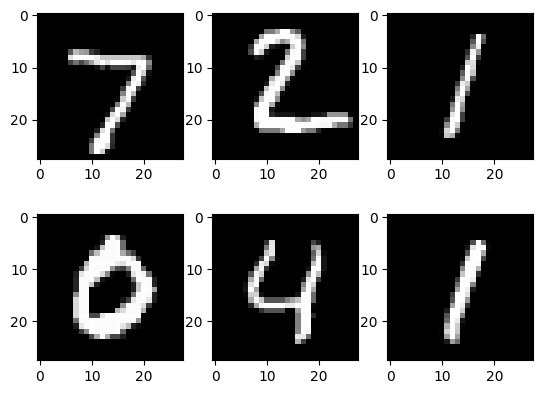

In [6]:
#plotting some examples from the MNIST dataset
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [7]:
train_images = train_dataset.data
train_labels = train_dataset.targets
test_images = test_dataset.data
test_labels = test_dataset.targets

In [8]:
print(f"Train image shape:{train_images.shape}")
print(f"Training Targets shape:{train_labels.shape}")

print(f"Test image shape:{test_images.shape}")
print(f"Test Targets shape:{test_labels.shape}")

Train image shape:torch.Size([60000, 28, 28])
Training Targets shape:torch.Size([60000])
Test image shape:torch.Size([10000, 28, 28])
Test Targets shape:torch.Size([10000])


# Comparing PCA and Autoencoders

**PCA on MNIST images taking only the first 30 eigenvalues with their corresponding eigenvectors. Project the data onto these eigenvectors and reconstruct them.**

<function matplotlib.pyplot.show(close=None, block=None)>

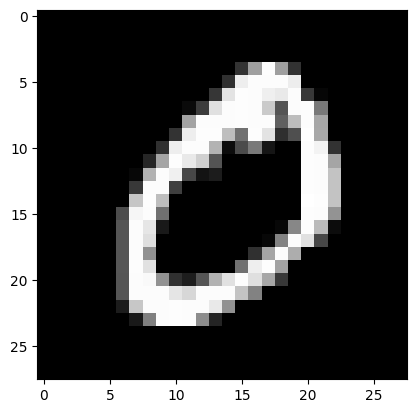

In [9]:
plt.imshow(train_images[1],cmap='gray')
plt.show

In [10]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse

print('PCA with 30 principal components')
train_data = np.asarray(train_images)/255
test_data = np.asarray(test_images)/255
PCA_data = train_data.reshape(-1,28*28)

pca1 = PCA(n_components = 30) #first 30 eigenvectors corresponding to top 30 eigenvalues
pca1.fit(PCA_data)
train_pca = pca1.transform(PCA_data)
reconstructed_data = pca1.inverse_transform(train_pca)
PCA_error = mse(PCA_data,reconstructed_data)
print('Reconstruction error made by PCA: ',PCA_error)

PCA with 30 principal components
Reconstruction error made by PCA:  0.018121658637615303


In [11]:
import random
def pca_reconstructed_images(input_pca_data, reconstructed_data):
    list_of_indices = np.random.randint(low=0, high=9999, size=5)
    for index in list_of_indices:
        input_image = np.asarray(255*input_pca_data[index],dtype = np.uint8).reshape(28,28)
        reconstructed_image = np.asarray(255*reconstructed_data[index],dtype = np.uint8).reshape(28,28)
        plt.subplot(1,2,1)
        plt.imshow(input_image , cmap='gray')
        plt.title('input image')
        plt.subplot(1,2,2)
        plt.imshow(reconstructed_image , cmap='gray')
        plt.title('reconstructed image')
        plt.show()
        

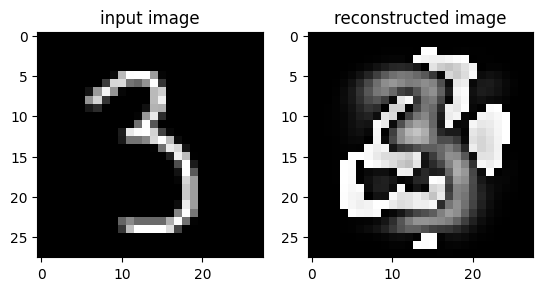

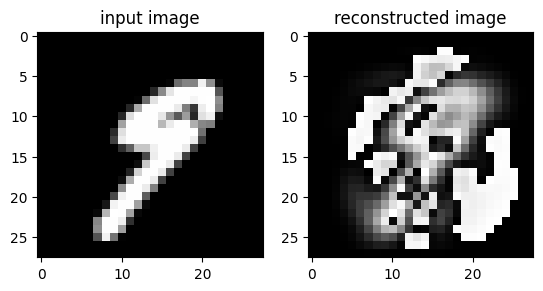

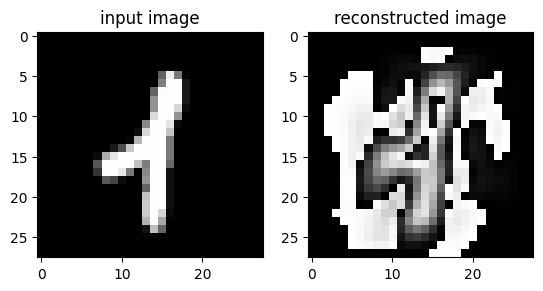

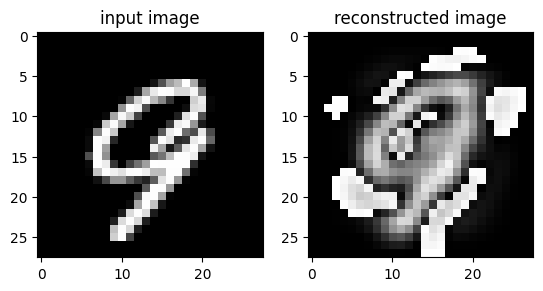

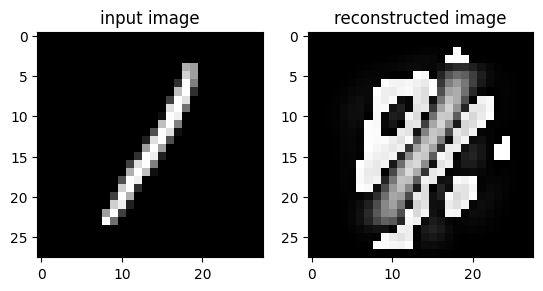

In [12]:
pca_reconstructed_images(PCA_data, reconstructed_data)

**Train an autoencoder with the following architecture:**<br/>
• Encoder <br/>
– input (784) <br/>
– fc (512) <br/>
– fc (256) <br/>
– fc (128) <br/>
– fc (30) <br/>
• Decoder <br/>
– fc (128) <br/>
– fc (256) <br/>
– fc (784) <br/>
Use ReLU as the activation function. Show the training and validation accuracy plot. Compare the Reconstruction Accuracy.
Also Compare visually by plotting outputs for each of the class for both PCA and autoencoder

In [13]:
class AE_Q1(nn.Module):
    def __init__(self): 
        super(AE_Q1,self).__init__() 
        #encoder module
        self.encoder = nn.Sequential(
            nn.Linear(784,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,30)
        )
        #decoder module
        self.decoder = nn.Sequential(
            nn.Linear(30,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,784),
            nn.ReLU()
        )
        
    def forward(self,x): 
        x = flatten(x,1) #flatten the image to a 784x1 vector
        encoded_input = self.encoder(x.float())
        reconstructed_input = self.decoder(encoded_input)
        return reconstructed_input,encoded_input

In [14]:
# Loss function
lossfn = nn.MSELoss()

In [15]:
from torch import flatten
def train(model,device,train_dataloader,optimizer,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3, q5_flag = False):
    model.train() 
    train_loss    = 0
    for batch_idx, (data,label) in enumerate(train_dataloader):  # (data,label): Training data for that batch
        if denoise==True:
            img = data.clone()
            data = add_noise(img,noise_val)
            data = data.to(device) 
        else:
            (data,label) = (data.to(device),label.to(device))  
            
        reconstruction,encoded = model(data) #reconstruction
        if q5_flag==True:
            loss = lossfn(reconstruction,data) #loss 
        else:
            loss = lossfn(reconstruction,flatten(data,1)) #loss 
        if sparse==True:
            loss += lambda_reg*torch.linalg.norm(encoded,1) 
        optimizer.zero_grad() 
        loss.backward()      
        optimizer.step()      #updating the weights
        train_loss    += loss/len(train_dataloader)
    return train_loss 

In [16]:
def test(model,device,test_dataloader,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3, q5_flag = False):
    model.eval() 
    test_loss    = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: # (data,label): Test data for that batch
            if denoise==True:
                img = data.clone()
                data = add_noise(img,noise_val)
                data = data.to(device)
            else:
                (data,label) = (data.to(device),label.to(device))  
            reconstruction,encoded = model(data) 
            if q5_flag==True:
                loss = lossfn(reconstruction,data) 
            else:
                 loss = lossfn(reconstruction,flatten(data,1)) 
            if sparse==True:
                loss += lambda_reg*torch.linalg.norm(encoded,1) 
            test_loss    += loss/len(test_dataloader)
    return test_loss 

In [17]:
def train_test(model,device,train_loader,test_loader,optimizer,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3,q5_flag=False): 
    train_losses   = []
    test_losses    = []
    for epoch in range(num_epochs+1):
        #train the model
        train_loss = train(model,device,train_loader,optimizer,lossfn,lambda_reg,sparse,denoise,noise_val,q5_flag)
        train_losses.append(train_loss.item())
        #test the model
        test_loss = test(model,device,test_loader,lossfn,lambda_reg,sparse,denoise,noise_val,q5_flag)
        test_losses.append(test_loss.item())
    return train_losses, test_losses

In [18]:
def plot_reconstructed_image(model,device,img,model_name,q5_flag=False):
    with torch.no_grad():
        if q5_flag == False:
            if (device==torch.device("cuda")):
                img = img.view(-1,28,28).cuda().float()
            else:
                img = img.view(-1,28,28).float()
        else:
            if (device==torch.device("cuda")):
                img = img.reshape(1,1,28,28).cuda().float()
            else:
                img = img.reshape(1,1,28,28).float()
        reconstructed_image,encoded = model.forward(img) #as it is a single image directly running the forward pass
        reconstructed_image=reconstructed_image.detach().cpu().numpy()
        img = img.reshape(28,28).detach().cpu().numpy()
        plt.subplot(1,2,1)
        plt.imshow(img , cmap='gray')
        plt.title('input image')
        plt.subplots_adjust(right=1.5)
        plt.subplot(1,2,2)
        plt.imshow(reconstructed_image.reshape(28,28),cmap ='gray') #reconstructed image
        plt.title("Reconstructed image using "+ str(model_name))
        plt.show()

In [19]:
def plot_losses(train_losses, test_losses, model_name):
    train_interval = int(len(train_losses)/num_epochs)
    plt.plot(np.asarray(train_losses)[::train_interval])
    plt.title("MSE train loss using "+ str(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    test_interval = int(len(test_losses)/num_epochs)
    plt.plot(np.asarray(test_losses)[::test_interval])
    plt.title("MSE test loss using "+ str(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.show()

In [20]:
model_Q1 = AE_Q1().to(device) 
optimizer = torch.optim.Adam(model_Q1.parameters(), lr=learning_rate)
train_losses_AE_Q1 , test_losses_AE_Q1 = train_test(model_Q1,device,train_loader,test_loader,optimizer,lossfn)

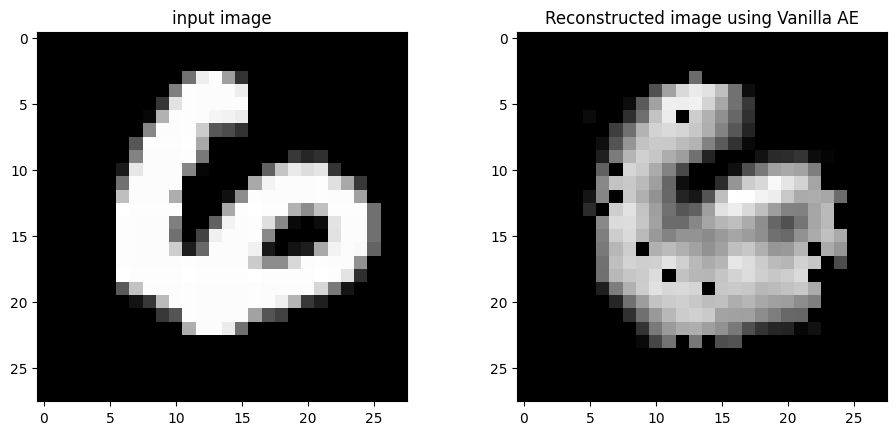

<class 'torch.Tensor'>


In [21]:
import random
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q1,device,test_image, model_name="Vanilla AE")
print(type(test_image))

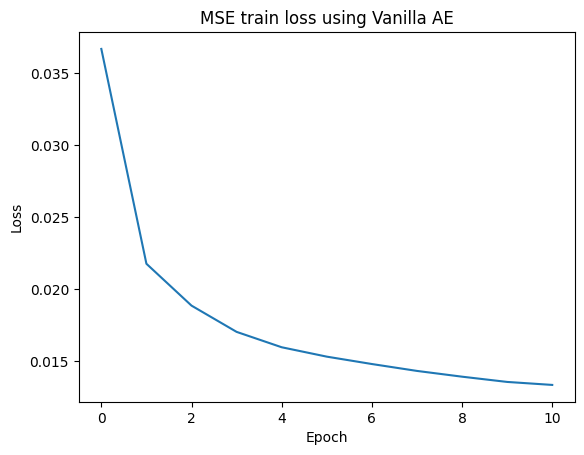

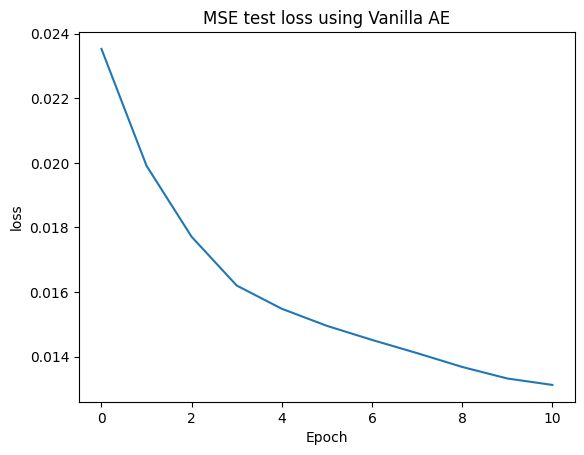

In [22]:
 plot_losses(train_losses_AE_Q1, test_losses_AE_Q1, model_name = "Vanilla AE")

In [23]:
#MSE recomnstruction error for vanilla AE
mse_error = test(model_Q1,device,test_loader,lossfn)
print("MSE Reconstruction error for Vanilla AE is ", mse_error.item())

MSE Reconstruction error for Vanilla AE is  0.013127011246979237


# Experimenting with hidden units of varying sizes

Train a standard auto-encoder with the following architecture:<br/>
• fc(x)-fc(784),<br/>
Here, x is the size of the hidden unit. The architecture consists of only a hidden layer and the output layer. Using x =
[64, 128, 256], do the following:
1. Plot the Training and validation accuracy plot for the 3 cases
2. Test the network on any one of your testset images and compare the quality of reconstruction for different values of x.
This comparison should be done visually.
3. What outputs do you get if you pass a non-digit image (Try Fashion MNIST) and random noise images through the
network?

In [24]:
class AE_Q2(nn.Module):
    def __init__(self,hidden_layer): 
        super(AE_Q2,self).__init__()
        #encoder 
        self.encoder = nn.Sequential(
            nn.Linear(784,hidden_layer),
            nn.ReLU()
        )
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_layer,784),
            nn.ReLU()
        )
        
    def forward(self,x): 
        x = flatten(x,1) 
        encoded_input = self.encoder(x.float())
        reconstructed_input = self.decoder(encoded_input)
        return reconstructed_input,encoded_input

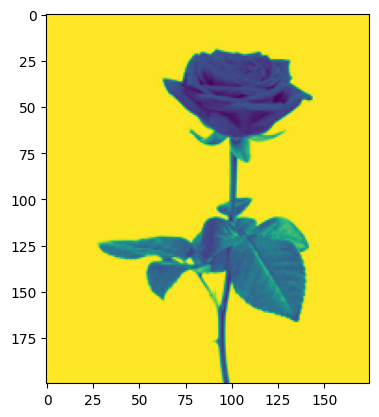

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
flower = cv2.imread("flower.png")
flower = cv2.cvtColor(flower, cv2.COLOR_BGR2GRAY)
plt.imshow(flower)

In [26]:
flower.shape

(200, 175)

In [27]:
import skimage.transform 
from skimage import img_as_ubyte
flower = np.asarray(flower)
non_digit_image = torch.from_numpy(img_as_ubyte(skimage.transform.resize(flower, (28,28)))) 

In [28]:
type(non_digit_image)

torch.Tensor

In [29]:
X = np.random.normal(loc=128,scale=10,size=(28,28)) #Initializing a 28x28 matrix with gaussian noise 1ith mean = 128, std=10
#converting X to Tensor
if(device==torch.device("cuda")):
    noisy_image = torch.from_numpy(X).reshape(1,1,28,28).cuda().float()
else:
    noisy_image = torch.from_numpy(X).reshape(1,1,28,28).float()

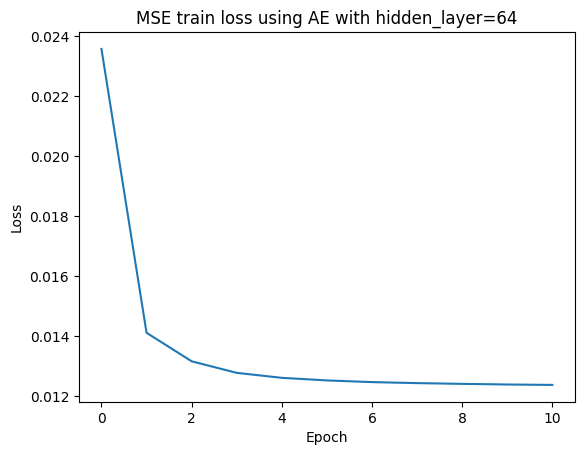

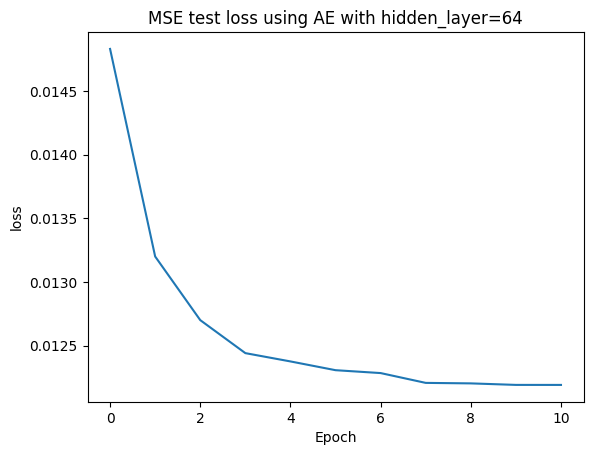

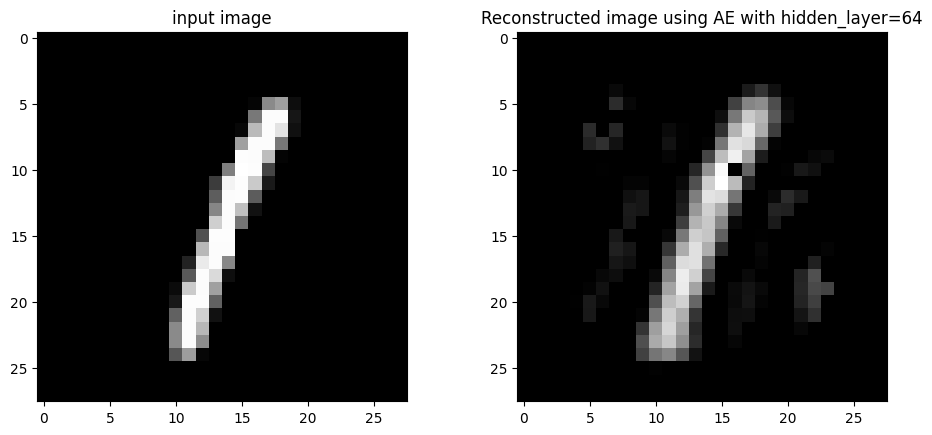

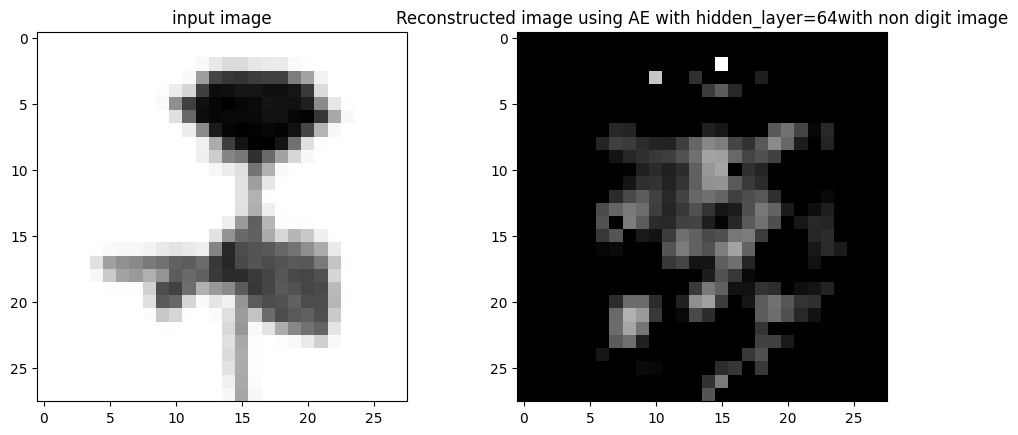

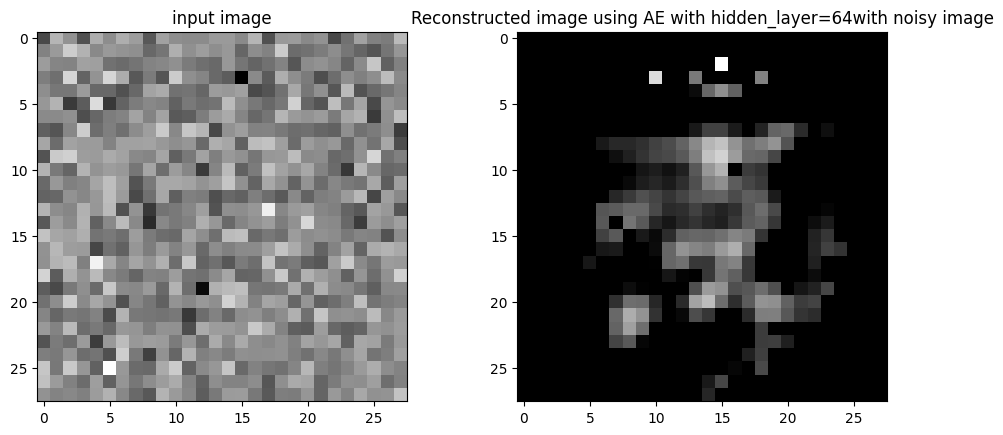

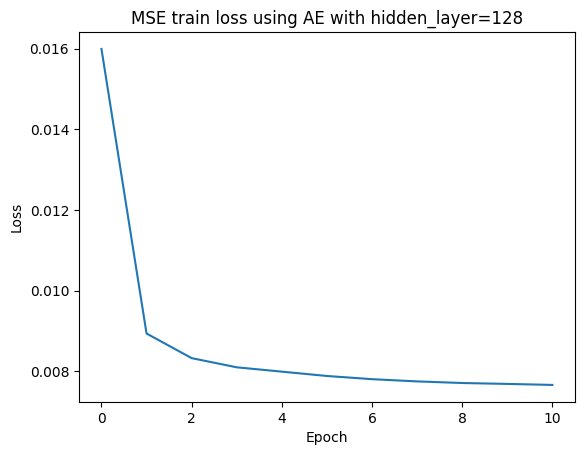

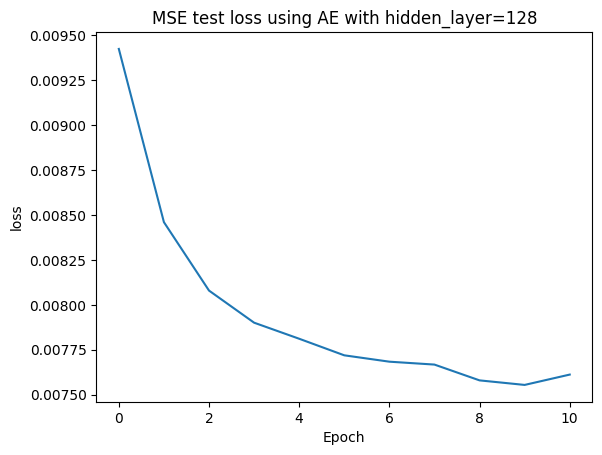

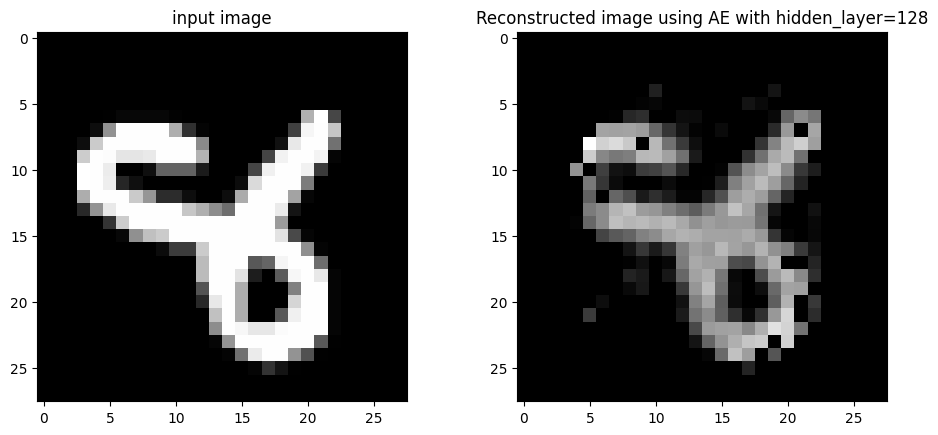

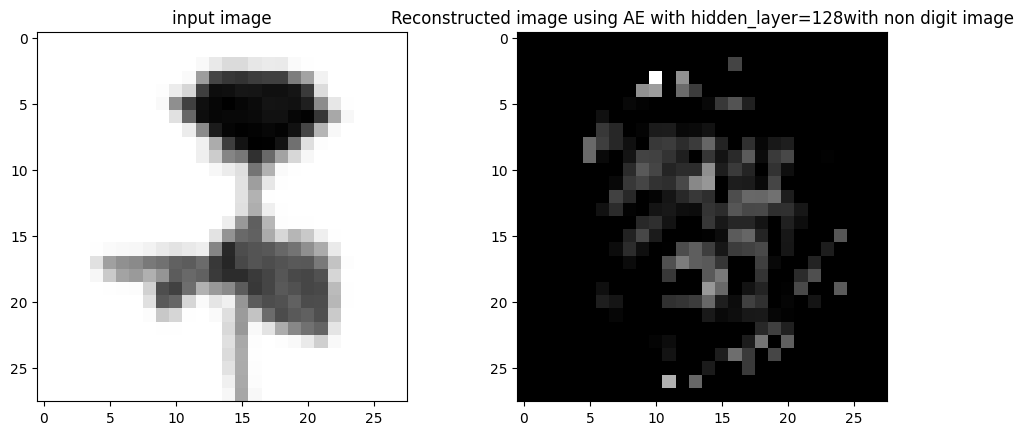

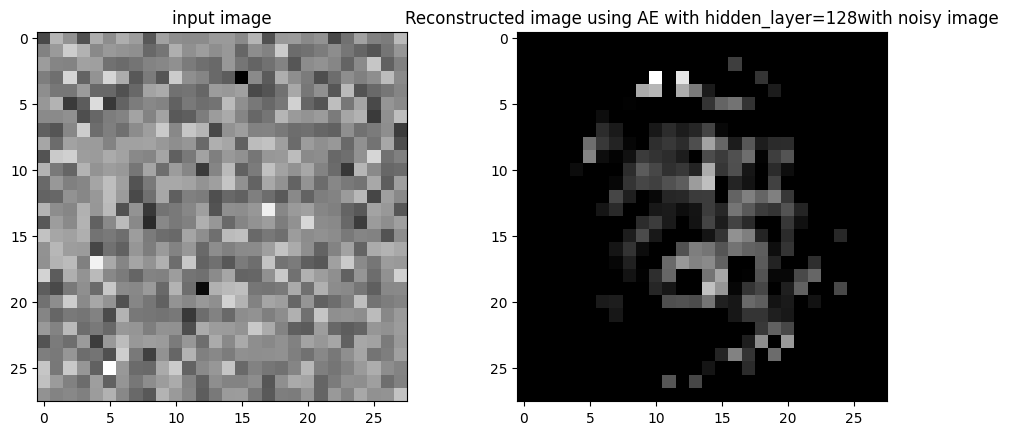

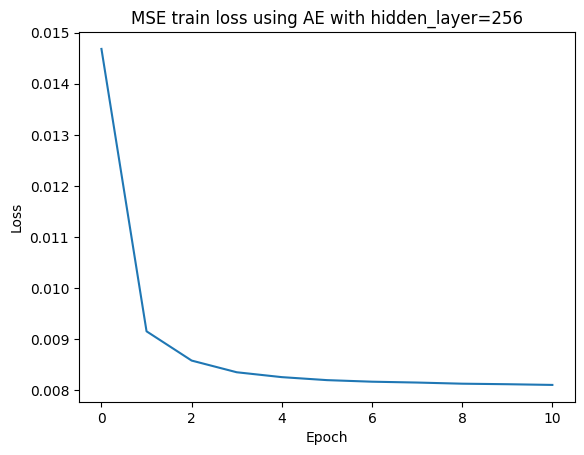

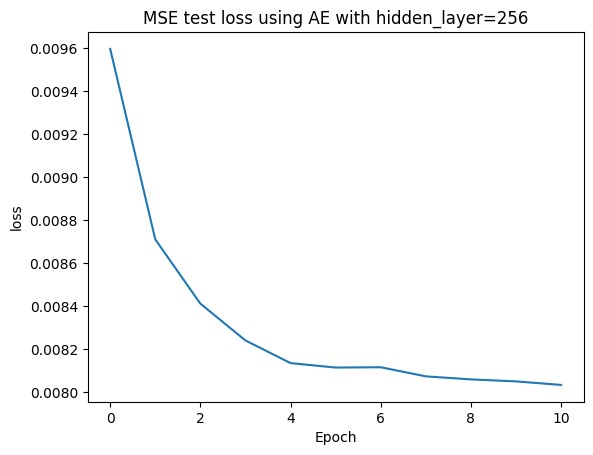

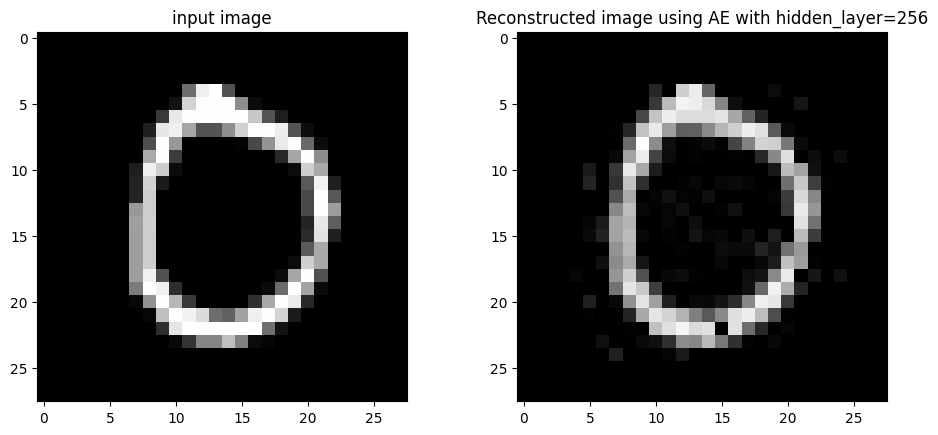

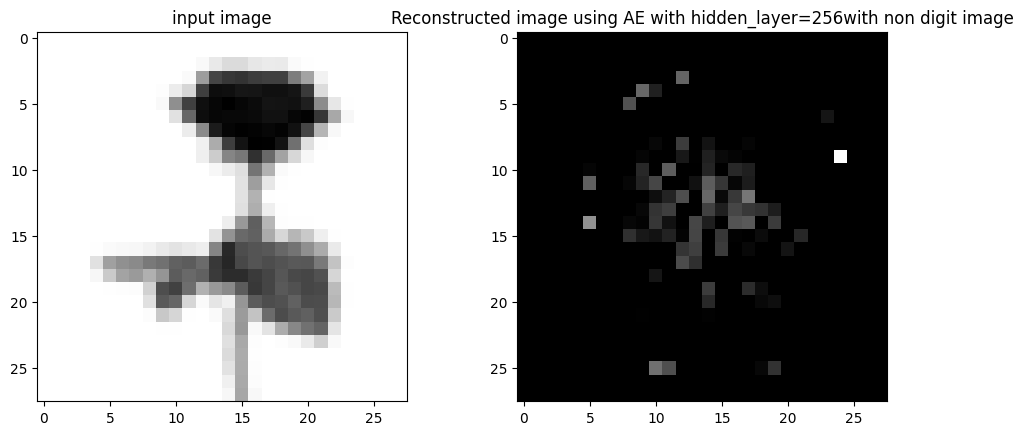

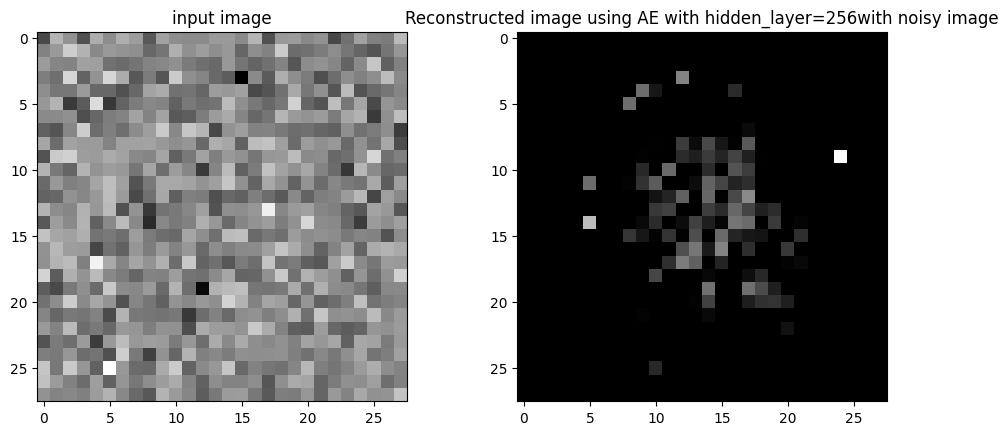

In [30]:
x = [64,128,256] #size of the hidden layer
for hidden_layer in x:
    model_Q2 = AE_Q2(hidden_layer=hidden_layer).to(device)
    optimizer = torch.optim.Adam(model_Q2.parameters(), lr=learning_rate)
    train_losses_AE_h , test_losses_AE_h = train_test(model_Q2,device,train_loader,test_loader,optimizer,lossfn)
    plot_losses(train_losses_AE_h, test_losses_AE_h, model_name = "AE with hidden_layer="+str(hidden_layer))
    index = random.randint(0,9999)
    test_image = test_loader.dataset.data[index, :, :].clone()
    plot_reconstructed_image(model_Q2,device,test_image, model_name="AE with hidden_layer="+str(hidden_layer))
    plot_reconstructed_image(model_Q2,device,non_digit_image, model_name="AE with hidden_layer="+str(hidden_layer)+"with non digit image")
    plot_reconstructed_image(model_Q2,device,noisy_image, model_name="AE with hidden_layer="+str(hidden_layer)+"with noisy image")

In [31]:
#print MSE reconstruction error
x = [64,128,256] #size of the hidden layer
for hidden_layer in x:
    mse_error = 0
    model_Q2 = AE_Q2(hidden_layer=hidden_layer).to(device)
    optimizer = torch.optim.Adam(model_Q2.parameters(), lr=learning_rate)
    mse_error = test(model_Q2,device,test_loader,lossfn)
    print("MSE Reconstruction error for AE with hidden layer size "+str(hidden_layer)+ " is ", mse_error.item())

MSE Reconstruction error for AE with hidden layer size 64 is  0.10725796967744827
MSE Reconstruction error for AE with hidden layer size 128 is  0.10778968781232834
MSE Reconstruction error for AE with hidden layer size 256 is  0.10910765081644058


# Sparse Autoencoders

Design an over-complete autoencoder with Sparsity regularization (Check L1 Penalty in torch). We impose sparsity by adding
L1 penalty on the hidden layer activation. L1 penalty is nothing but L1 norm on the output of hidden layer. Here, the
parameter controls the degree of sparsity (the one you pass to L1 Penalty function while defining the model). Higher the value,more sparser the activations are. You can vary the value of this parameter and observe the change in filter visualizations. Also, if the sparsity is too much, it could lead to bad reconstruction error.<br/>
1. Plot the training-validation plot for the different sparsity values chosen
2. Compare the average hidden layer activations of the Sparse AutoEncoder with that of the Standard AutoEncoder (in
the above question). Also compare visually the differences in the output for different sparsities. What differences do
you observe?
3. Now, try to visualize the learned filters of this Sparse AutoEncoder as images. What difference do you observe in the
structure of these filters from the ones you learned using the Standard AutoEncoder?

In [32]:
class AE_Q3(nn.Module):
    def __init__(self): 
        super(AE_Q3,self).__init__() 
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(784,961), #overcomplete autoencoder 
            nn.ReLU()
        )
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(961,784),
            nn.ReLU()
        )
        
    def forward(self,x): 
        x = flatten(x,1) 
        encoded_input = self.encoder(x.float())
        reconstructed_input = self.decoder(encoded_input)
        return reconstructed_input,encoded_input

Function to calculate Average hidden layer activations 

In [33]:
def avg_hl_activations(model,test_dataloader,model_name):
    model.eval() 
    avg_act_val = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: 
            (data,label) = (data.to(device),label.to(device))  
            reconstruction,encoded = model(data)
            avg_act_val += float(torch.mean(encoded))        
    avg_act_val /= len(test_dataloader)
    print("The average activation of "+ str(model_name)+" is",avg_act_val)

In [34]:
def encoder_decoder_filters_plots(model,model_name,device): 
    with torch.no_grad():
        encoder_filters = model.encoder[0].weight.detach().cpu().numpy()
        decoder_filters = model.decoder[0].weight.detach().cpu().numpy()
        #plot the encoder and decoder weights as an image for 0th neuron
        plt.imshow(encoder_filters[0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Encoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

        plt.imshow(decoder_filters[:,0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Decoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

In [35]:
def visualize_activations(model,test_dataloader,model_name,device,hidden_layer):
    data_ind  = np.random.randint(low=0, high=9999, size=5)
    for i,ind in enumerate(data_ind):
        test_image = test_dataloader.dataset.data[ind].clone()  #copy of the test_image 
        test_label = test_dataloader.dataset.targets[ind].clone()
        with torch.no_grad():
            if(device == torch.device("cuda")): 
                test_image = test_image.reshape(1,1,28,28).cuda().float() #reshaping the image into 28x28 
            else:
                test_image = test_image.reshape(1,1,28,28).float()
            reconstructed_image,encoded = model.forward(test_image) 
            encoded = encoded.detach().cpu().numpy()
            plt.imshow(encoded.reshape(int(np.sqrt(hidden_layer)),int(np.sqrt(hidden_layer))), cmap='gray') 
            str_title = "Activation for digit "+str(test_label.item())
            plt.title(str_title)
            plt.show()

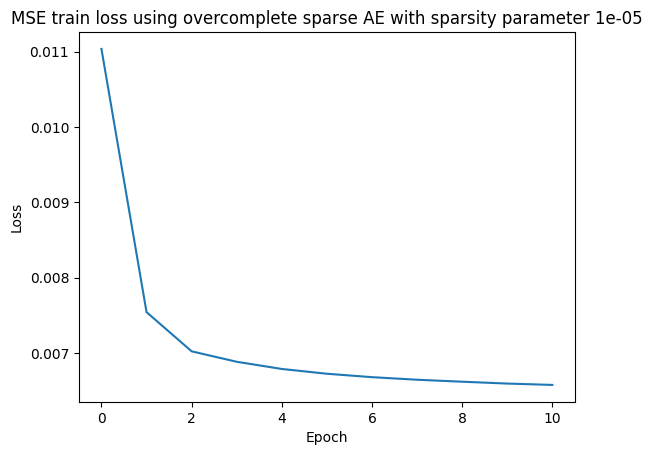

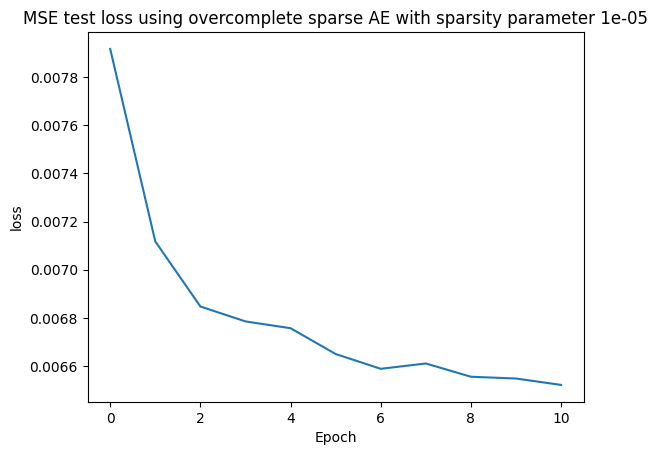

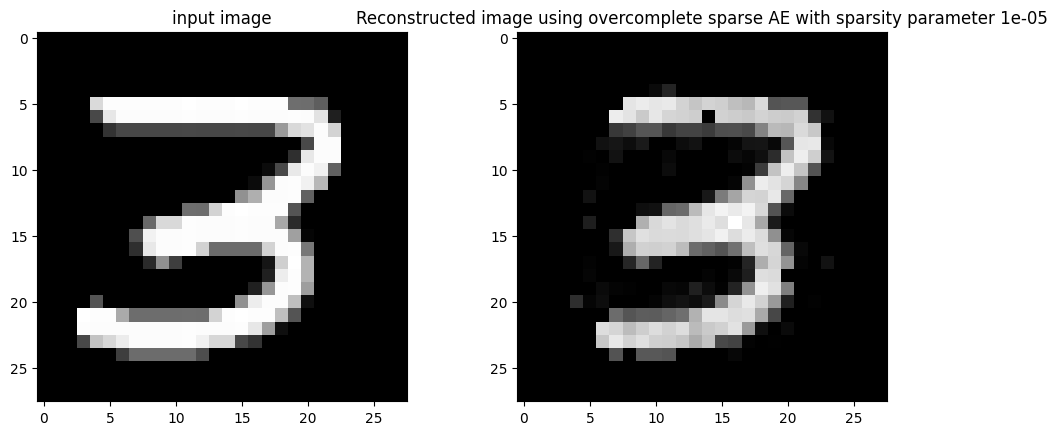

The average activation of overcomplete sparse AE with sparsity parameter 1e-05 is 0.1797752103228478


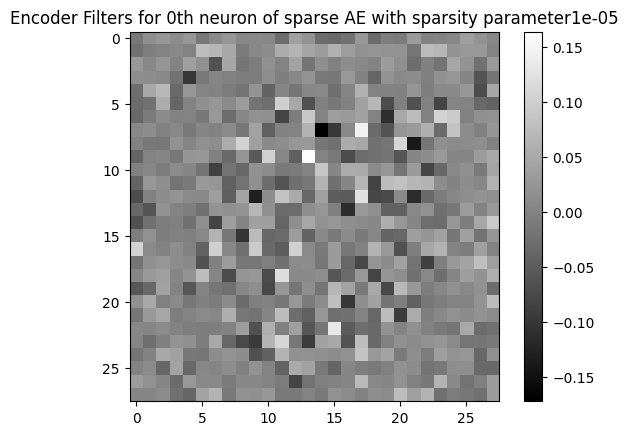

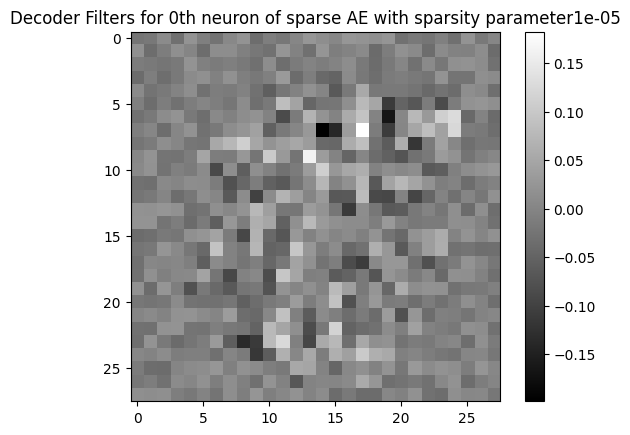

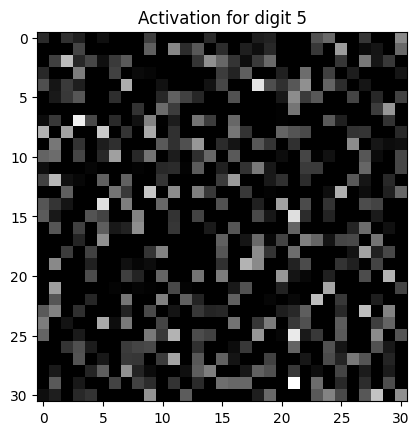

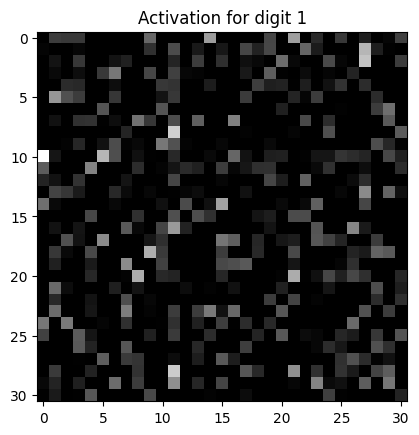

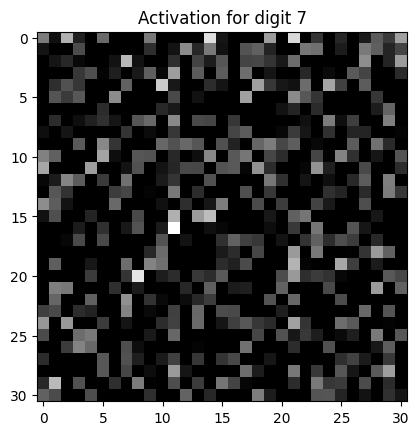

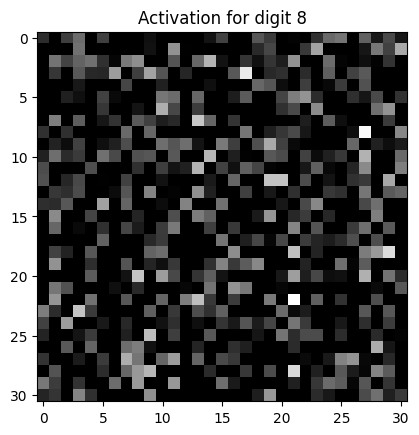

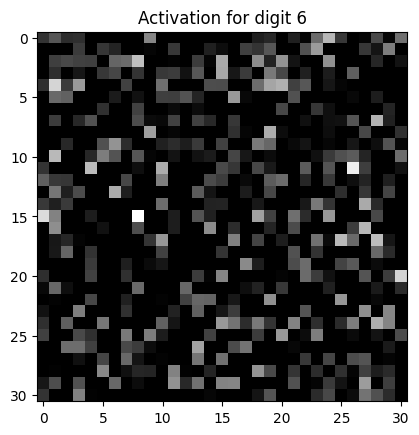

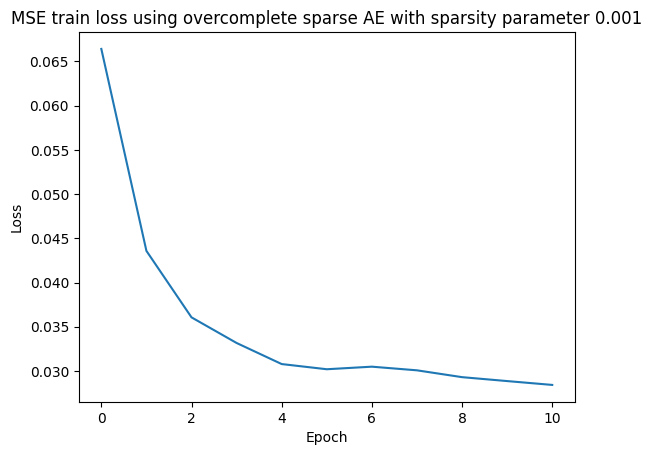

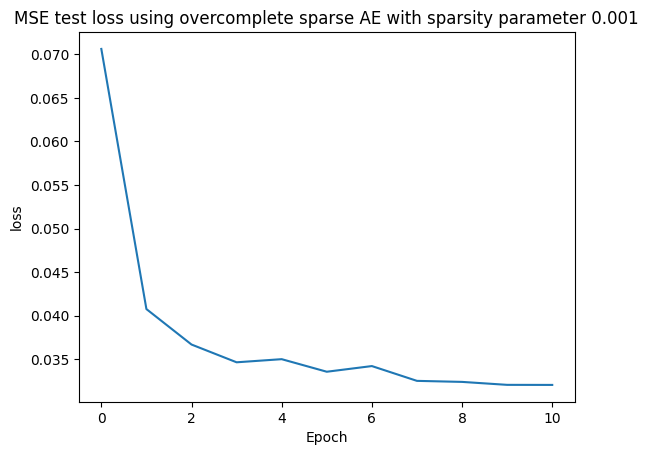

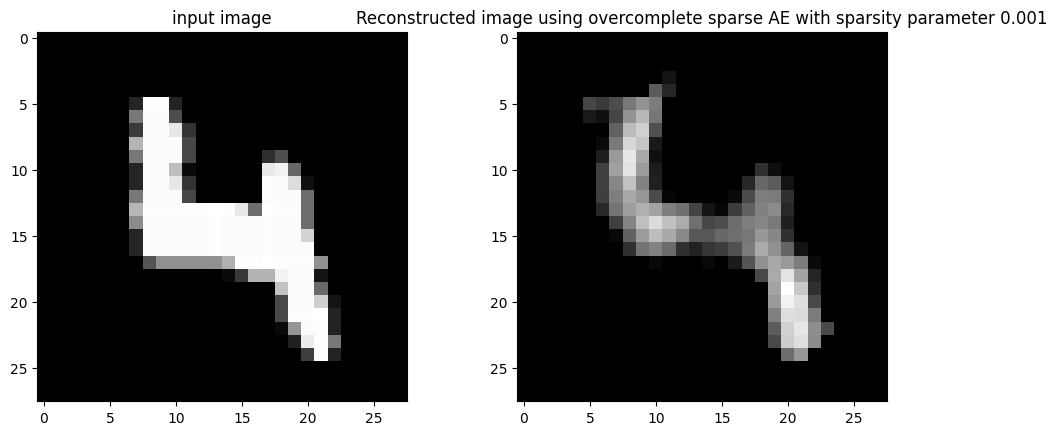

The average activation of overcomplete sparse AE with sparsity parameter 0.001 is 0.008272677535416594


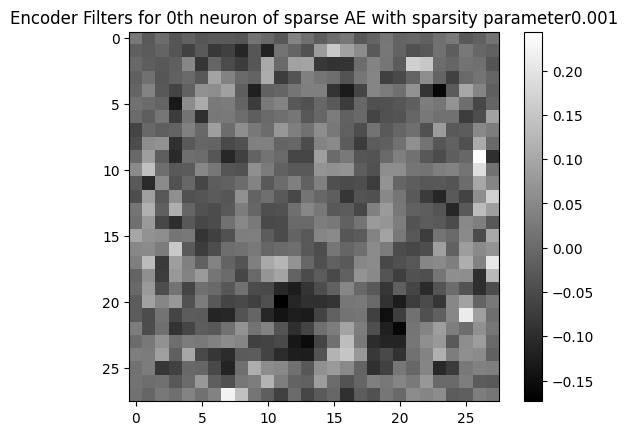

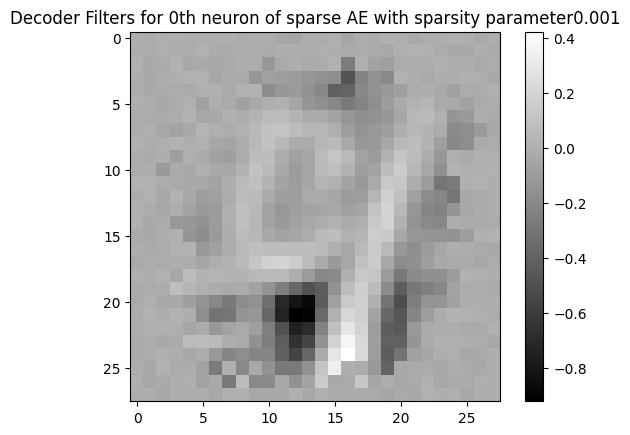

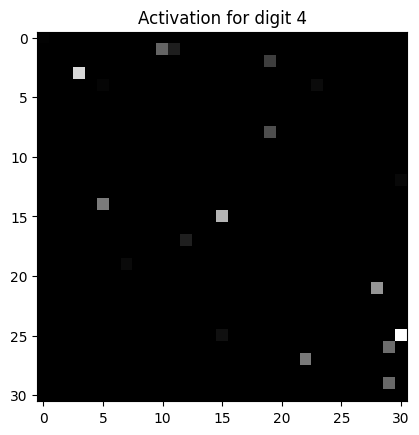

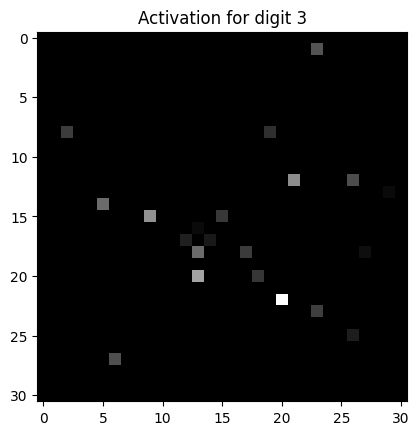

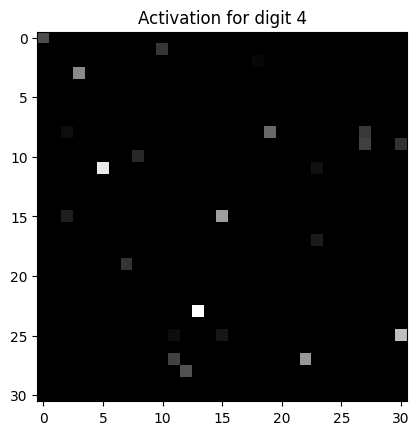

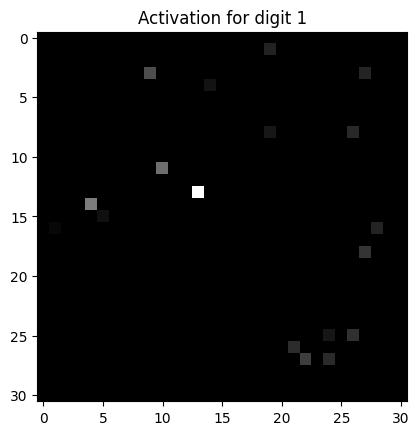

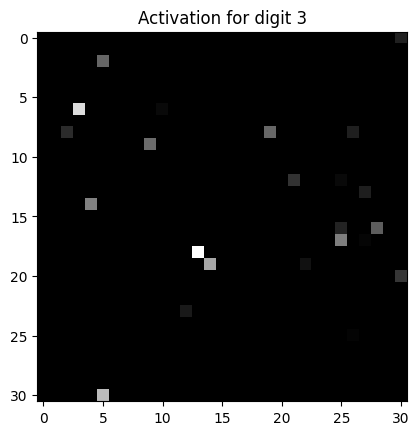

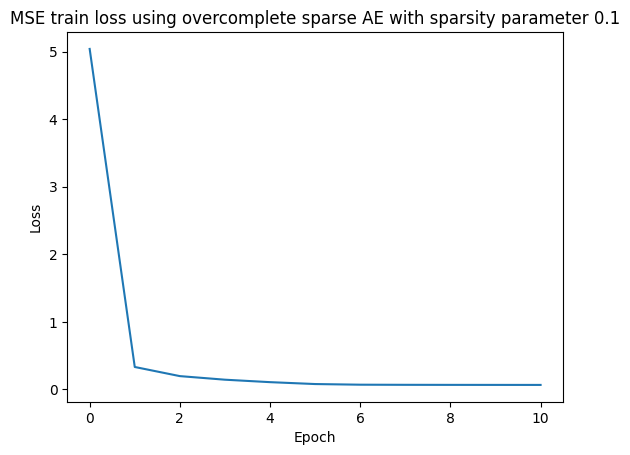

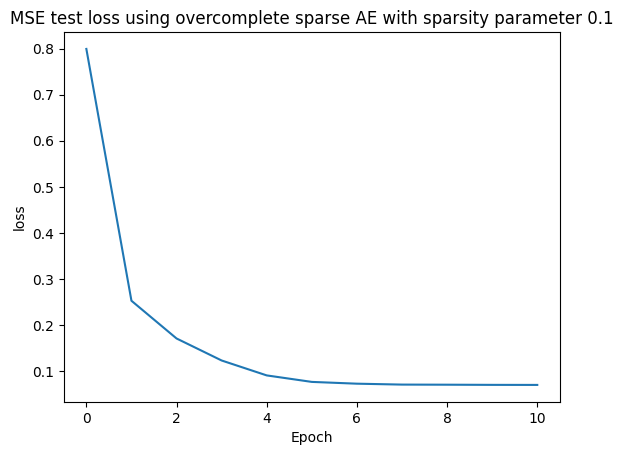

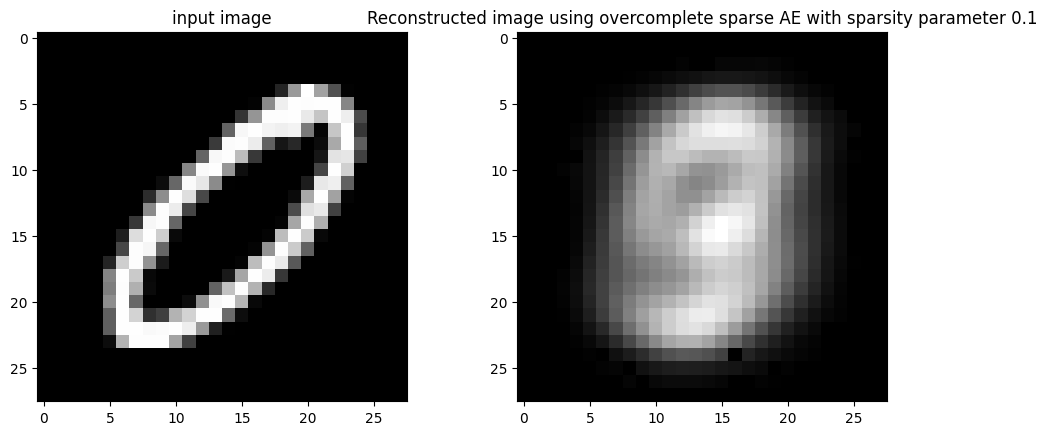

The average activation of overcomplete sparse AE with sparsity parameter 0.1 is 9.5650926742046e-07


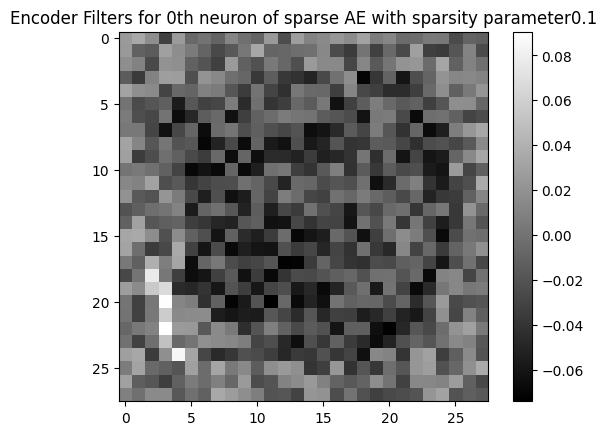

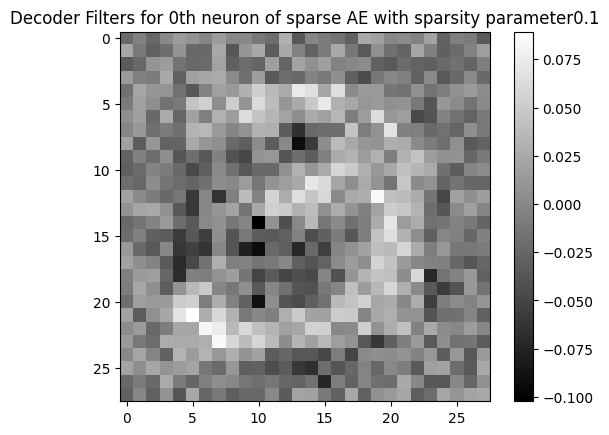

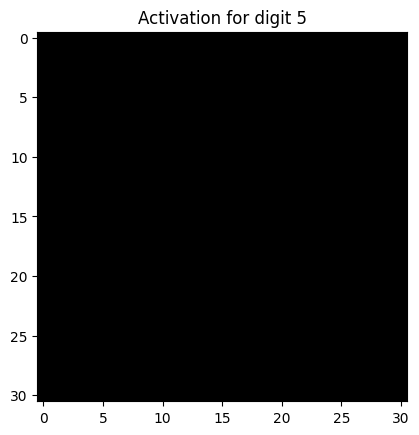

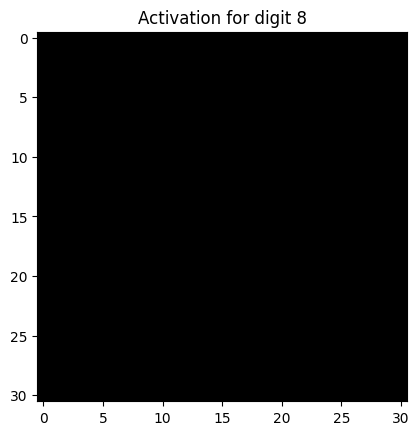

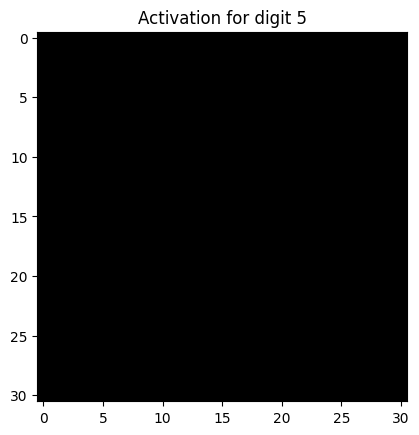

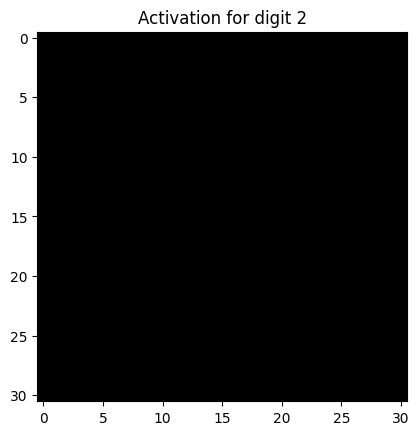

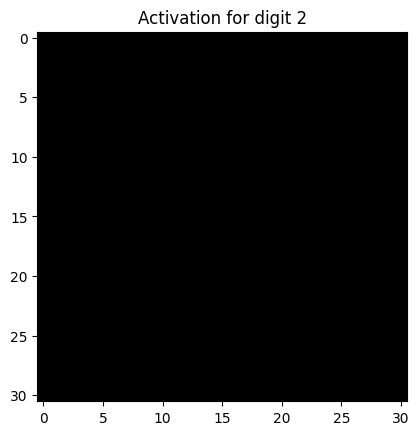

In [36]:
lambda_reg_vals=[0.00001, 0.001, 0.1]  
for lambda_reg in lambda_reg_vals:
    model_Q3 = AE_Q3().to(device)
    optimizer = torch.optim.Adam(model_Q3.parameters(), lr=learning_rate)
    train_losses_AE_Q3 , test_losses_AE_Q3 = train_test(model_Q3,device,train_loader,test_loader,optimizer,lossfn,lambda_reg,sparse=True)
    plot_losses(train_losses_AE_Q3, test_losses_AE_Q3, model_name = "overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    index = random.randint(0,9999)
    test_image = test_loader.dataset.data[index, :, :].clone()
    plot_reconstructed_image(model_Q3,device,test_image, model_name="overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    avg_hl_activations(model_Q3,test_loader,"overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    encoder_decoder_filters_plots(model_Q3,"sparse AE with sparsity parameter"+str(lambda_reg),device)
    visualize_activations(model_Q3,test_loader,"sparse AE with sparsity parameter"+str(lambda_reg),device,961)

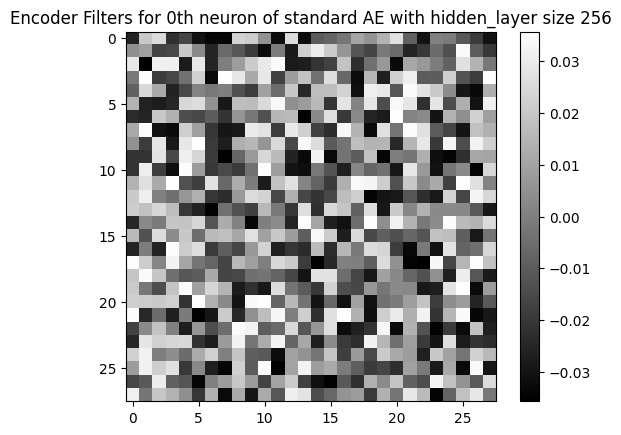

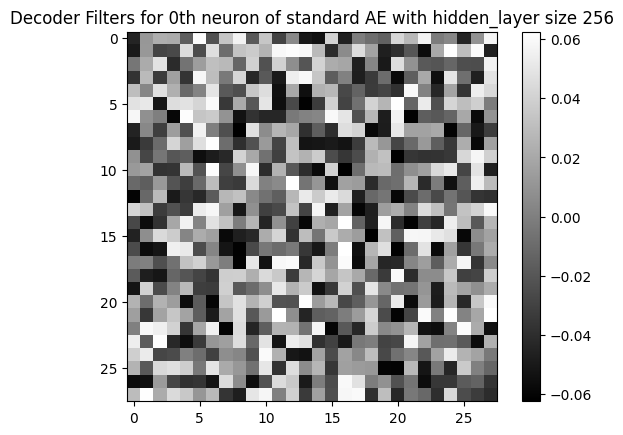

In [37]:
encoder_decoder_filters_plots(model_Q2,"standard AE with hidden_layer size 256",device)

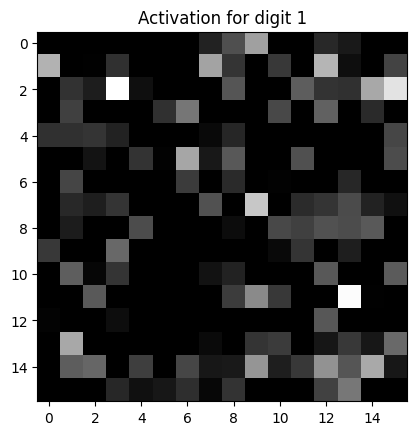

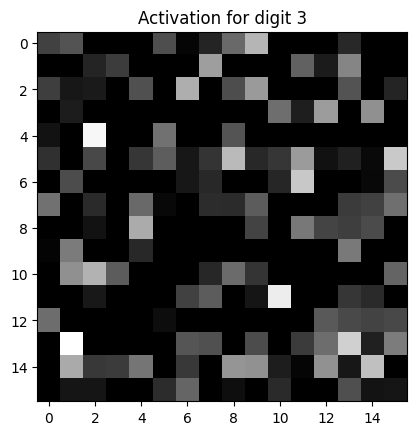

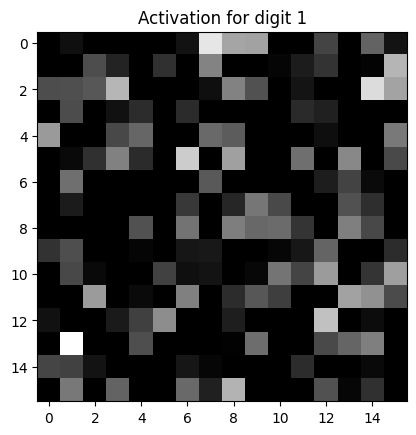

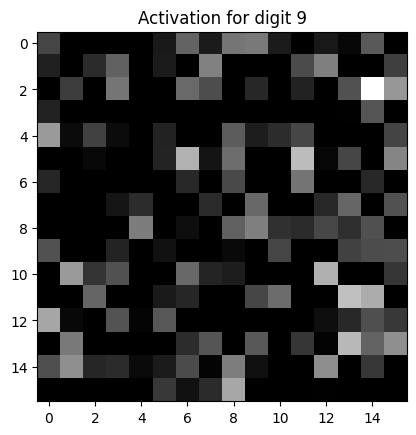

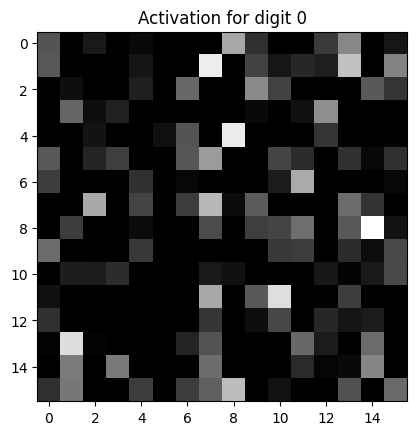

In [38]:
visualize_activations(model_Q2,test_loader,"Standard AE with hidden_layer=256",device,256)

In [39]:
avg_hl_activations(model_Q2,test_loader,"Standard AE with hidden_layer=256 ")

The average activation of Standard AE with hidden_layer=256  is 0.07100810338357452


# Denoising Autoencoders

Design a denoising autoencoder with just one hidden unit (Take hidden size as 256).
1. What happens when you pass images corrupted with noise to the previously trained Standard Autoencoders (From Q2)
? Compare it with Denoising autoencoders
2. Change the noise level (typical values: 0.3, 0.5, 0.8, 0.9) and repeat the above experiments. What kind of variations
do you observe in the results? (Both Visually and by MSE)
3. Visualize the learned filters for Denoising Autoencoders. Compare it with that of Standard Autoencoders. What
difference do you observe between them?

In [40]:
def add_noise(img, noise_val):
    noise = torch.randn(img.size())*noise_val
    noisy_img = img + noise
    return noisy_img

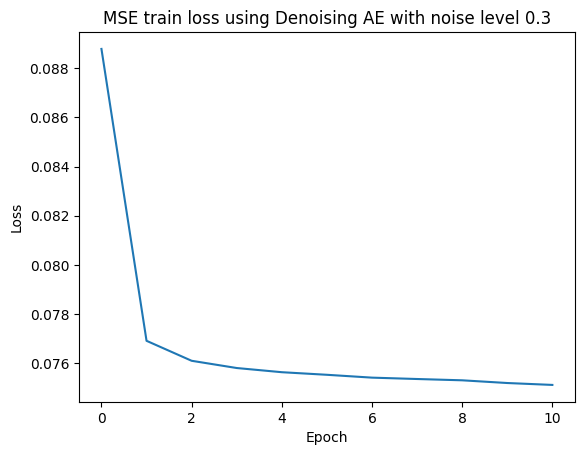

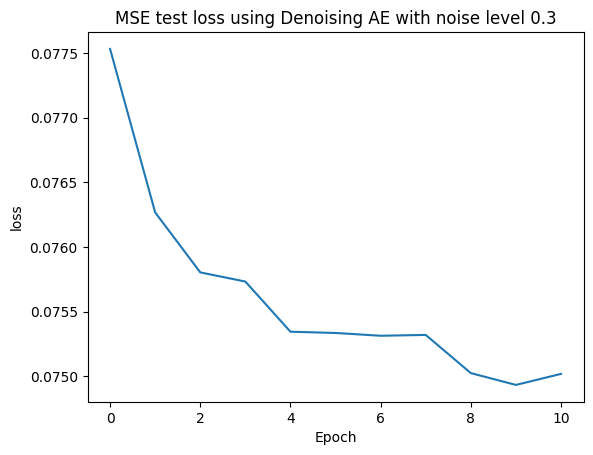

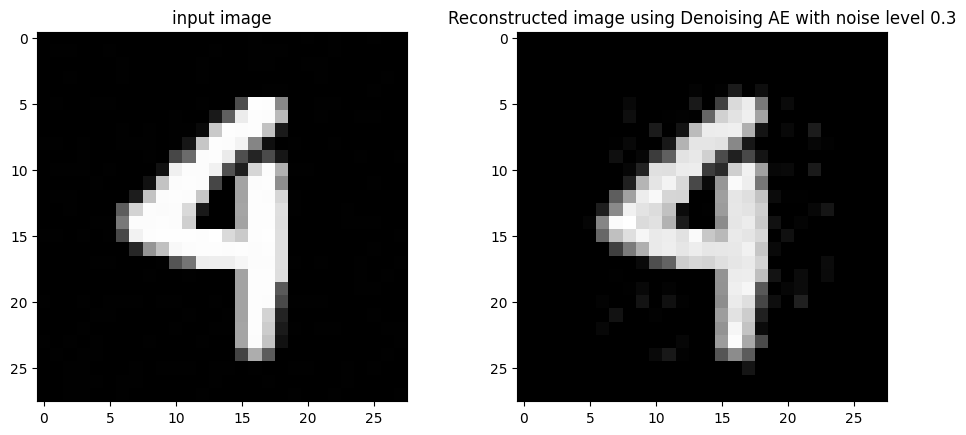

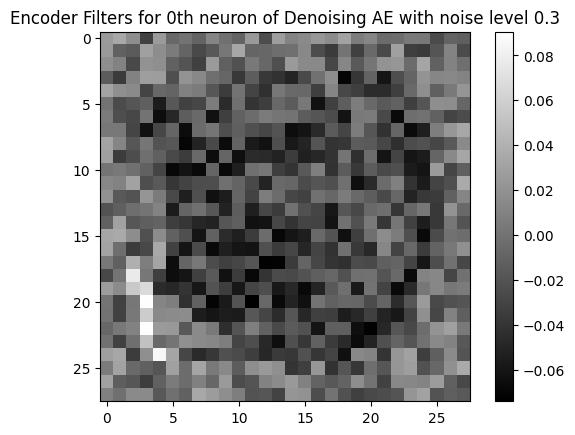

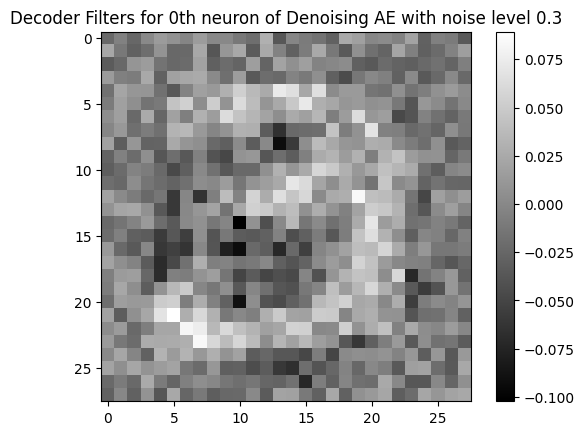

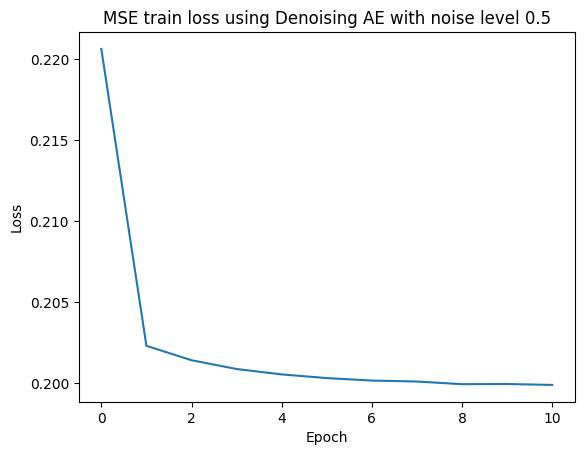

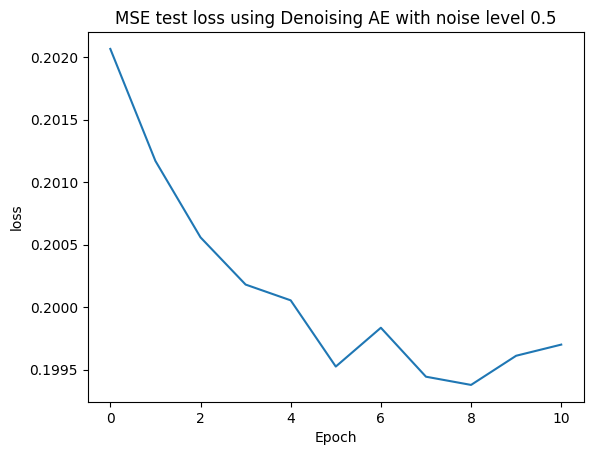

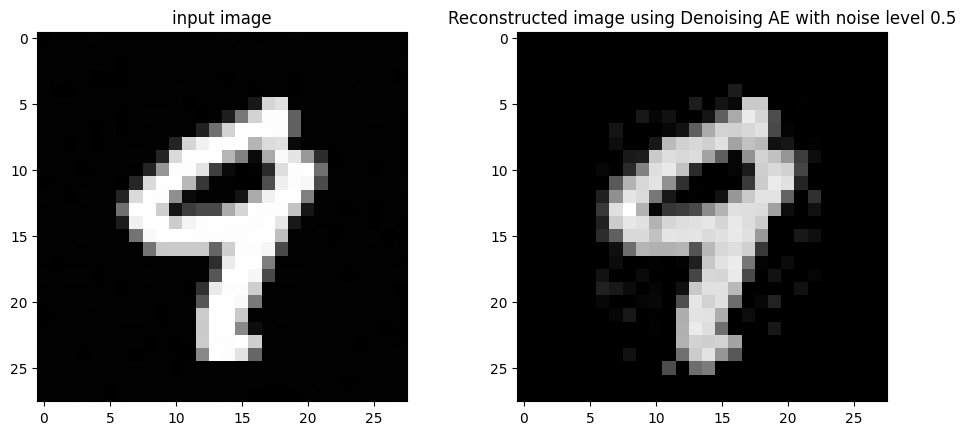

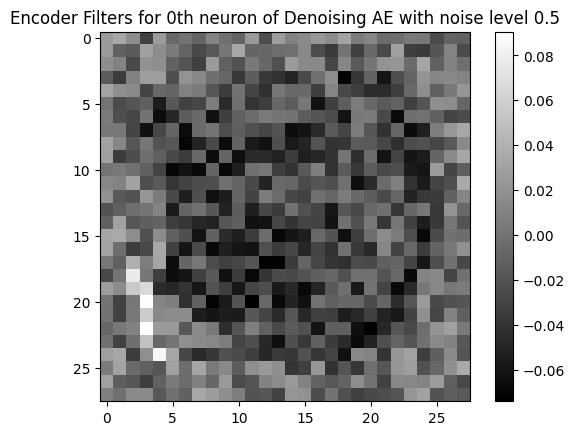

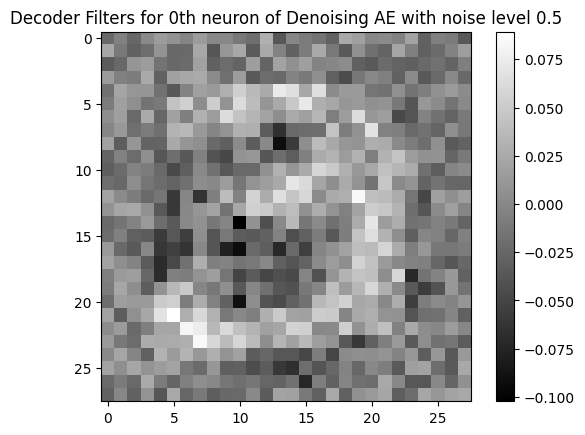

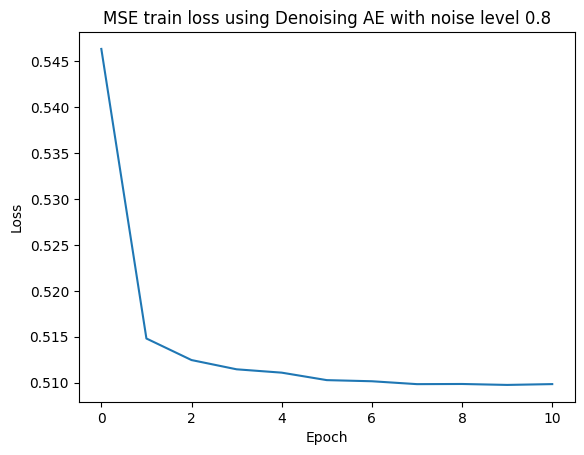

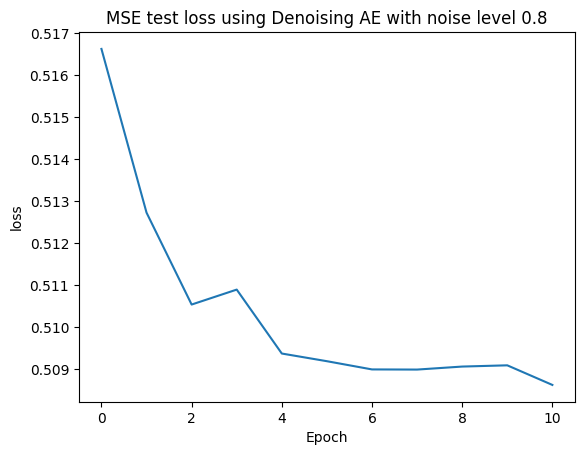

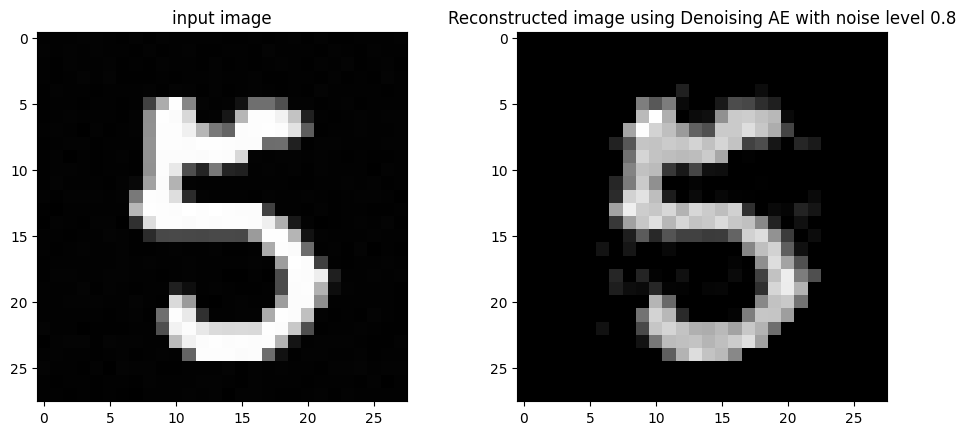

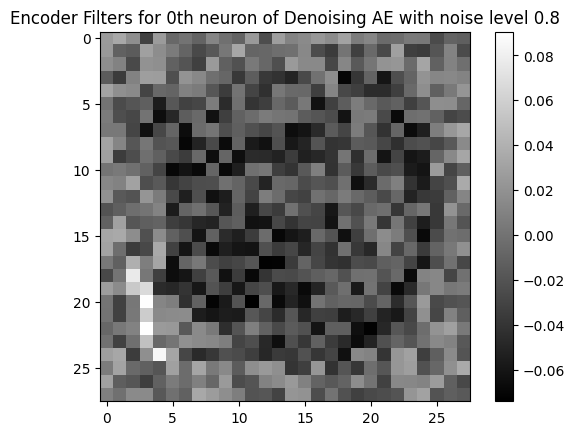

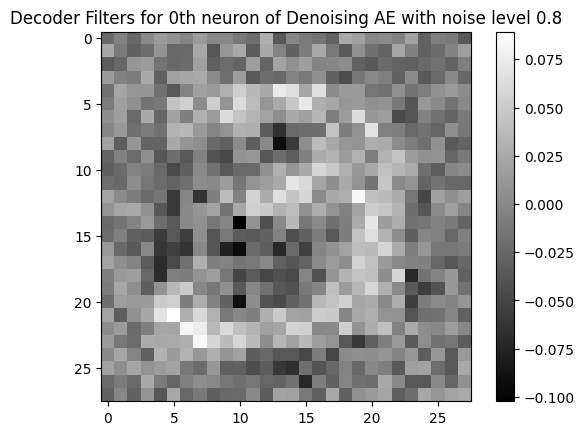

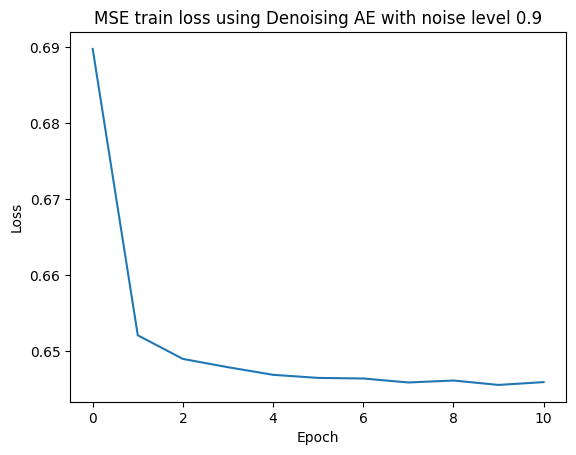

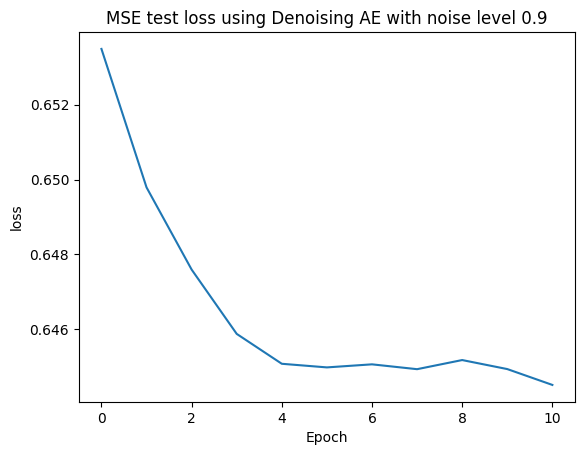

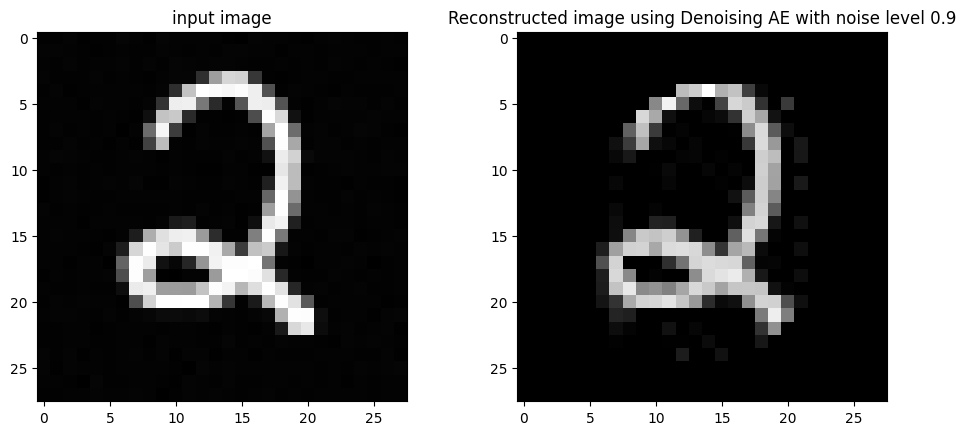

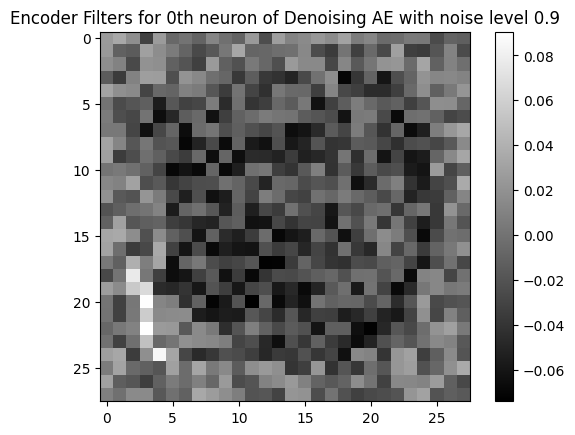

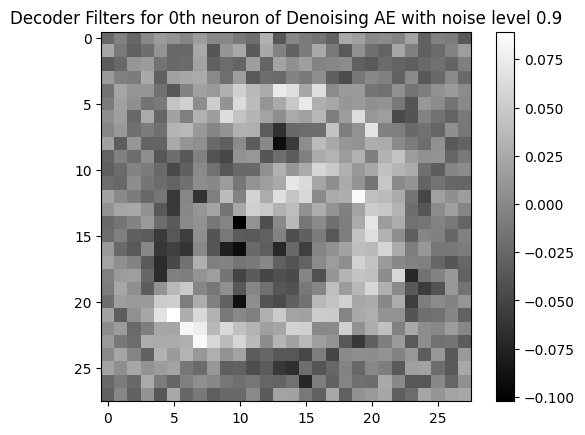

In [41]:
noise_vals = [0.3,0.5,0.8,0.9]
for noise_val in noise_vals:
    model_Q4 = AE_Q2(256).to(device)
    optimizer = torch.optim.Adam(model_Q4.parameters(), lr=learning_rate)
    train_losses_AE_Q4 , test_losses_AE_Q4 = train_test(model_Q4,device,train_loader,test_loader,optimizer,lossfn,denoise=True,noise_val=noise_val)
    plot_losses(train_losses_AE_Q4, test_losses_AE_Q4, model_name = "Denoising AE with noise level "+str(noise_val))
    index = random.randint(0,9999)
    test_image = test_loader.dataset.data[index, :, :].clone()
    test_image = add_noise(test_image,noise_val)
    plot_reconstructed_image(model_Q4,device,test_image, model_name="Denoising AE with noise level "+str(noise_val))
    encoder_decoder_filters_plots(model_Q3,"Denoising AE with noise level "+str(noise_val),device)


# Convolutional Autoencoders

AE can also be implemented as fully convolutional networks with the decoder consisting of upsampling operations of any of
these variants - i) Unpooling or ii) Unpooling + Deconvolution or iii) Deconvolution.
1. Train a Convolutional AE for the MNIST data with 3 convolutional layers for encoder and the decoder being the
mirror of encoder (i.e a total of 7 convolutional layers for AE with the final convolutional layer mapping to the output).
Architecture for the encoder part:<br/>
• Input-Conv1(8 3x3 filters with stride 1)<br/>
• 2x2 Maxpooling <br/>
• Conv2(16 3x3 filters with stride 1) <br/>
• 2x2 Maxpooling <br/>
• Conv3(16 3x3 filters with stride 1) <br/>
2. 
• 2x2 Maxpooling <br/>
At the output of the final 2x2 Maxpooling we have the encoded representation. This needs to followed by the
decoder network. Experiment with all the three types of upsampling.
Keeping all the other parameters the same, report on reconstruction error and convergence with the different types of
upsampling. Also visualize the decoder weights for the three cases. What do you observe?


In [42]:
class conv_AE_with_unpooling(nn.Module): 
    
    def __init__(self): 
        super(conv_AE_with_unpooling,self).__init__() 
        
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)     # 28x28x1 to 14x14x8
        ) 
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)      #14x14x8 to 7x7x16
        ) 
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)      #7x7x16 to 3x3x16
        ) 
        
        #decoder 
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),   #14x14x16 to 14x14x8
            nn.ReLU()
        ) 
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),    #28x28x8 to 28x28x1
            nn.ReLU()
        ) 
        
        #unpooling 
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): 
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16

        reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1
        
        return reconstructed_input,encoded_input

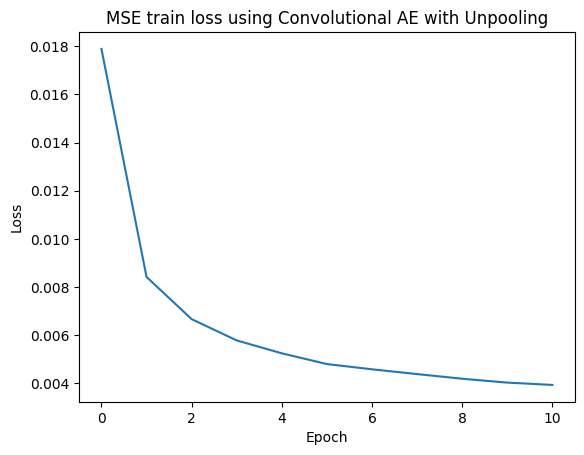

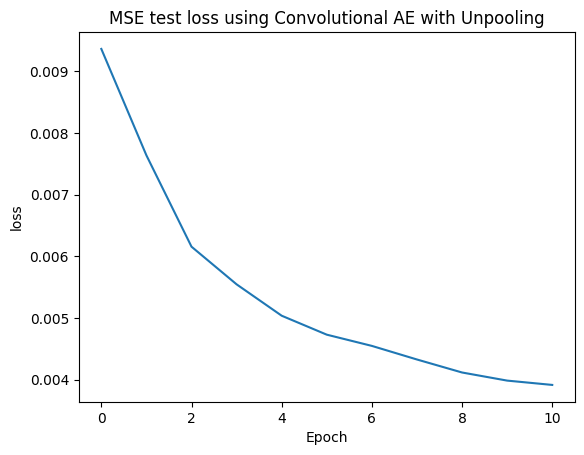

In [43]:
model_Q5_a = conv_AE_with_unpooling().to(device)
optimizer = torch.optim.Adam(model_Q5_a.parameters(), lr=learning_rate)
train_losses_AE_Q5_a , test_losses_AE_Q5_a = train_test(model_Q5_a,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_a, test_losses_AE_Q5_a, model_name = "Convolutional AE with Unpooling")

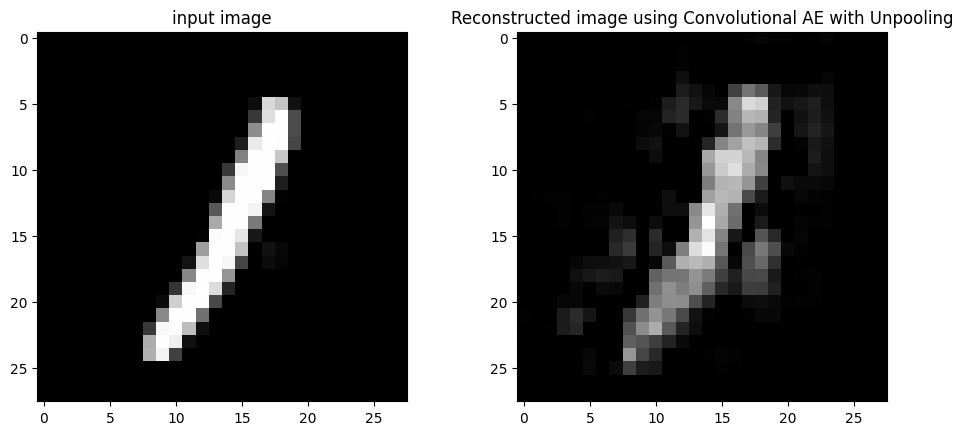

In [44]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_a,device,test_image, model_name="Convolutional AE with Unpooling",q5_flag=True)

In [68]:
class conv_AE_with_deconv(nn.Module):
    def __init__(self):
        super(conv_AE_with_deconv,self).__init__() 
        
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        
        #decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        
    def forward(self,x): 
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input = self.decoder_conv1(encoded_input)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input

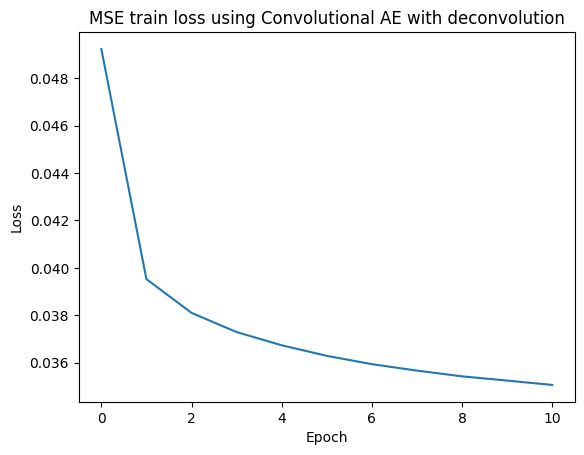

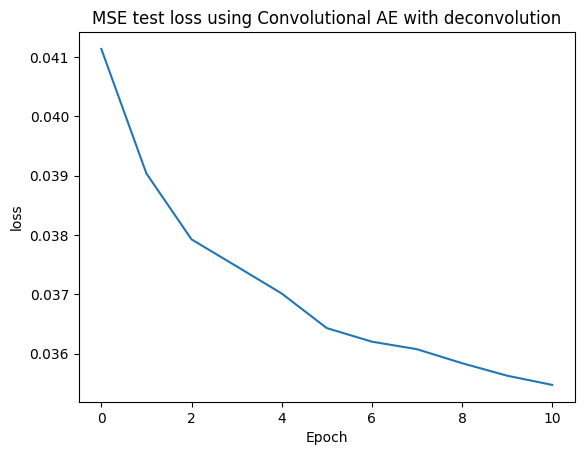

In [70]:
model_Q5_b1 = conv_AE_with_deconv().to(device)
optimizer = torch.optim.Adam(model_Q5_b1.parameters(), lr=learning_rate)
train_losses_AE_Q5_b1 , test_losses_AE_Q5_b1 = train_test(model_Q5_b1,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_b1, test_losses_AE_Q5_b1, model_name = "Convolutional AE with deconvolution")

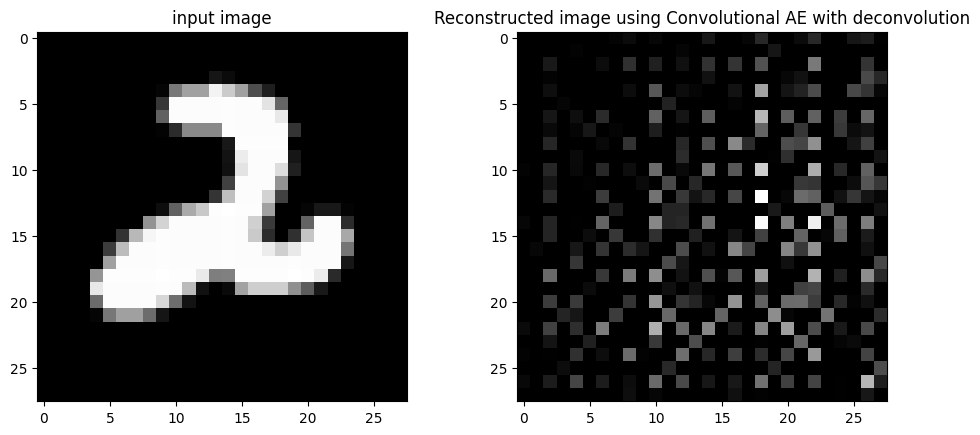

In [55]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_b,device,test_image, model_name="Convolutional AE with deconvolution",q5_flag=True)

In [56]:
class conv_AE_with_deconv_unpool(nn.Module):
    def __init__(self): 
        super(conv_AE_with_deconv_unpool,self).__init__() 
        
         #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        
        #decoder 
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        
        #unpooling 
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): 
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
    
        reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input = self.decoder_conv1(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices2)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices1)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input 

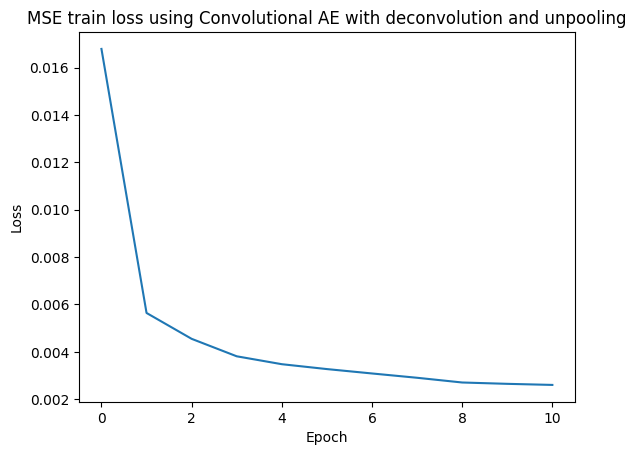

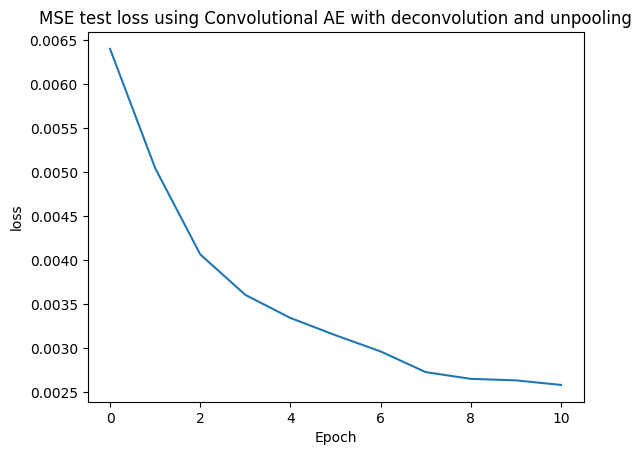

In [57]:
model_Q5_c = conv_AE_with_deconv_unpool().to(device)
optimizer = torch.optim.Adam(model_Q5_c.parameters(), lr=learning_rate)
train_losses_AE_Q5_c , test_losses_AE_Q5_c = train_test(model_Q5_c,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_c, test_losses_AE_Q5_c, model_name = "Convolutional AE with deconvolution and unpooling")

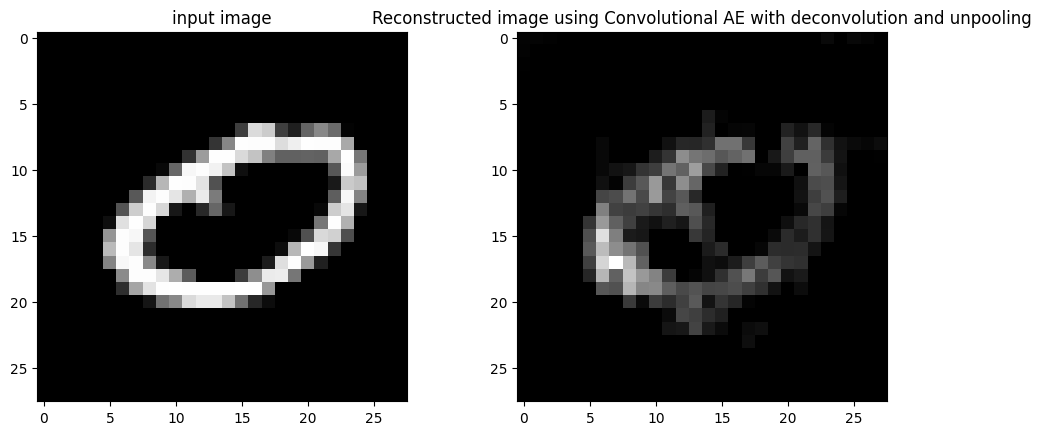

In [58]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_c,device,test_image, model_name="Convolutional AE with deconvolution and unpooling",q5_flag=True)

In [59]:
from torchvision.utils import make_grid 
def conv_AE_visualize_decoder_weights(model,model_name,device,decoder_conv_filter,decoder_layer):
    if(device == torch.device('cuda')):
        decoder_conv_filter = decoder_conv_filter.cpu()
    #normalize the filter weights
    decoder_conv_filter -= decoder_conv_filter.min()
    decoder_conv_filter /= decoder_conv_filter.max()
    (x,y,z,w) = decoder_conv_filter.size()
    filt_ind = np.random.randint(0 ,decoder_conv_filter.size()[0],3)
    for ind in filt_ind: 
        image = make_grid(decoder_conv_filter[ind].reshape(y,1,z,w)) 
        image = image.permute(1,2,0) 
        plt.imshow(image)
        plt.title("Decoder "+str(decoder_layer)+" Convolutional layer filter outputs for filter no. "+str(ind)+" of "+str(model_name))
        plt.show()

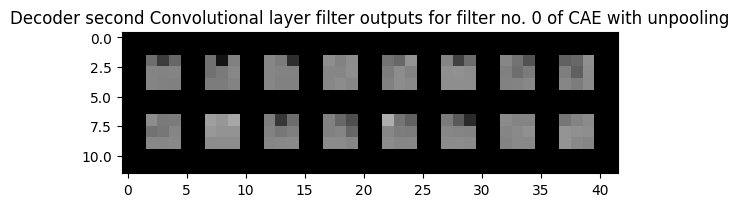

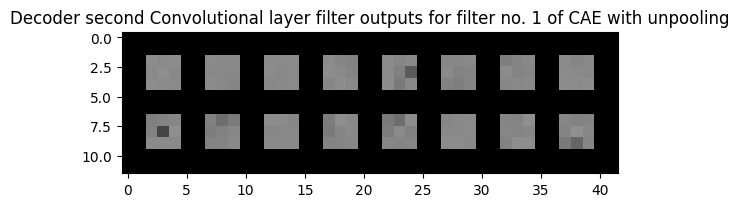

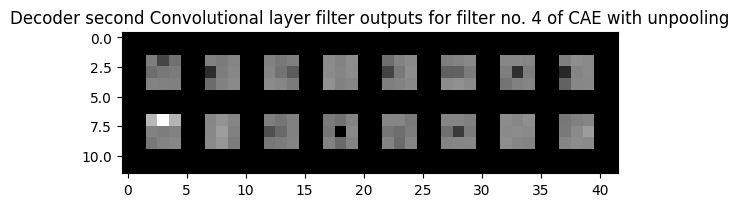

In [60]:
conv_2_filter = model_Q5_a.decoder_conv2[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_a,model_name="CAE with unpooling",device=device,decoder_conv_filter=conv_2_filter,decoder_layer="second")

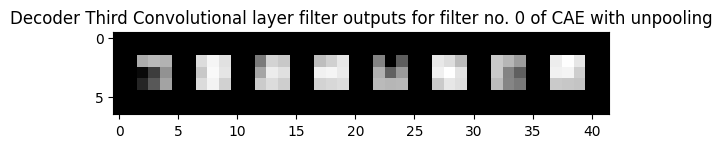

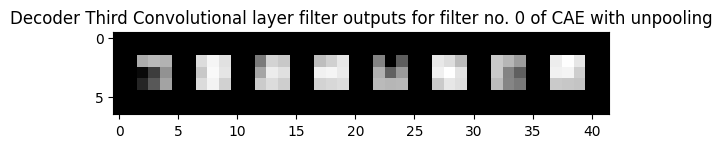

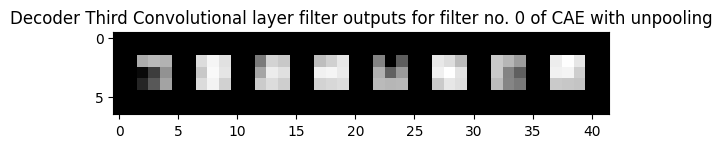

In [61]:
conv_3_filter = model_Q5_a.decoder_conv3[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_a,model_name="CAE with unpooling",device=device,decoder_conv_filter=conv_3_filter,decoder_layer="Third")

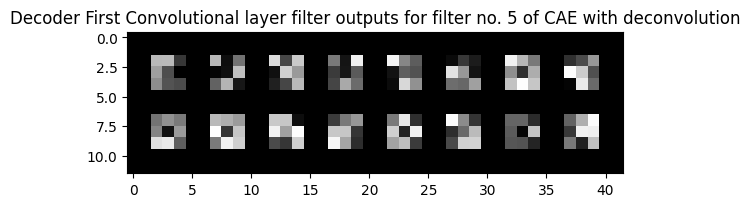

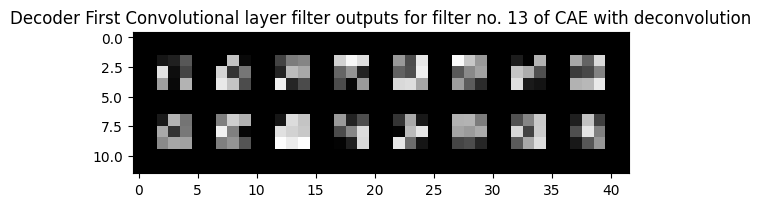

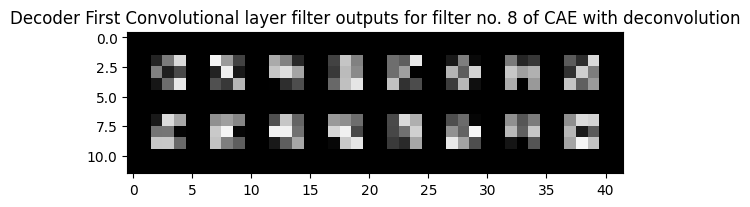

In [62]:
conv_1_filter = model_Q5_b.decoder_conv1[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="CAE with deconvolution",device=device,decoder_conv_filter=conv_1_filter,decoder_layer="First")

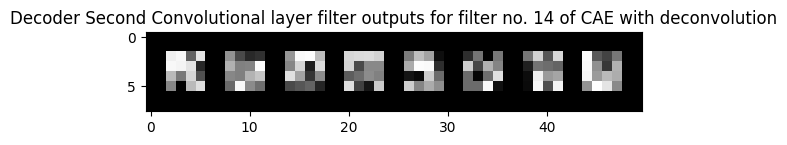

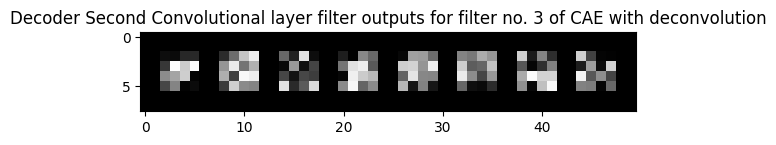

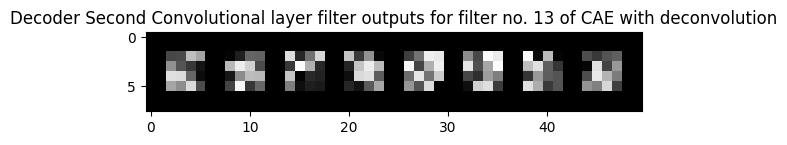

In [63]:
conv_2_filter = model_Q5_b.decoder_conv2[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="CAE with deconvolution",device=device,decoder_conv_filter=conv_2_filter,decoder_layer="Second")

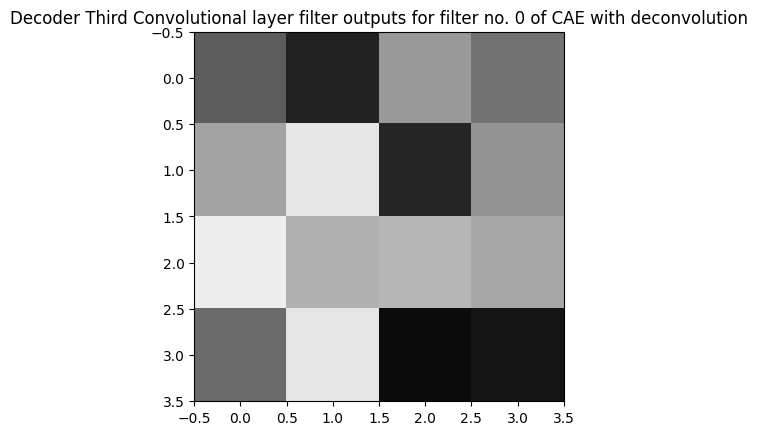

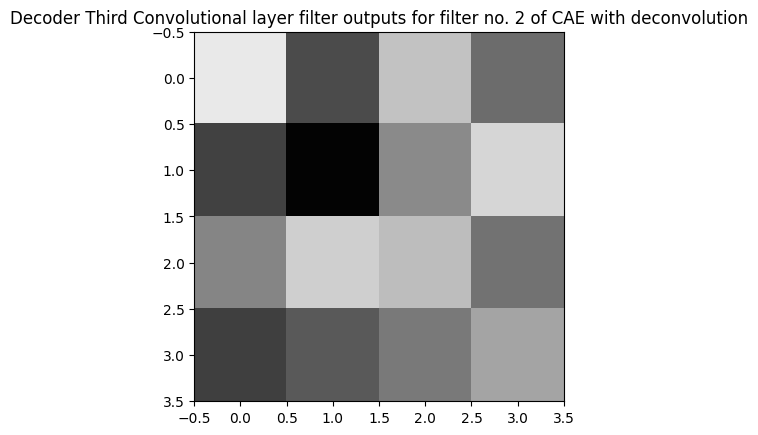

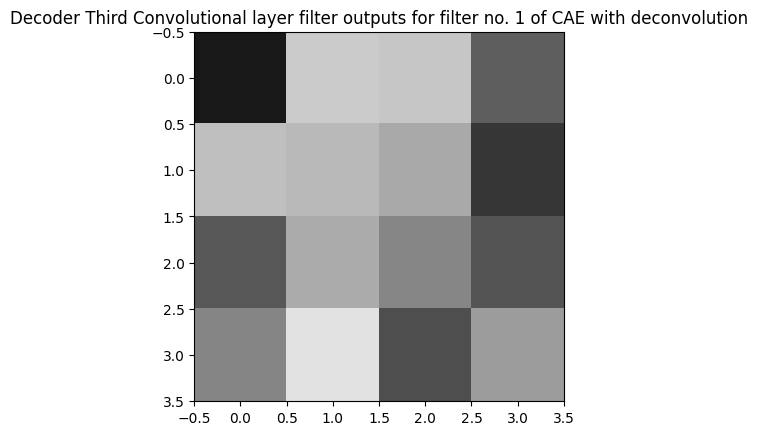

In [64]:
conv_3_filter = model_Q5_b.decoder_conv3[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="CAE with deconvolution",device=device,decoder_conv_filter=conv_3_filter,decoder_layer="Third")

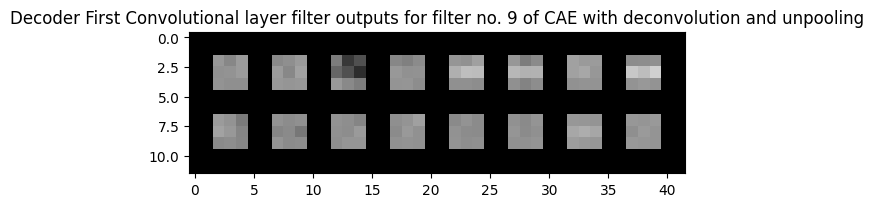

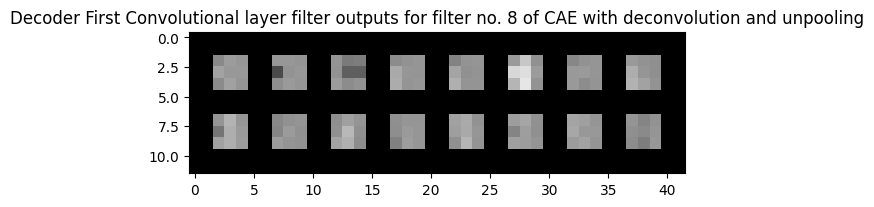

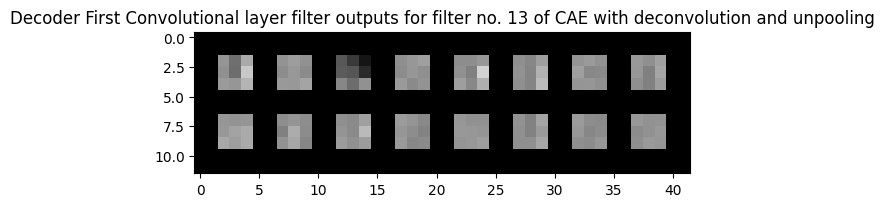

In [65]:
conv_1_filter = model_Q5_c.decoder_conv1[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_c,model_name="CAE with deconvolution and unpooling",device=device,decoder_conv_filter=conv_1_filter,decoder_layer="First")

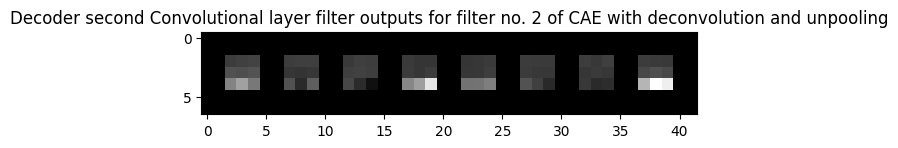

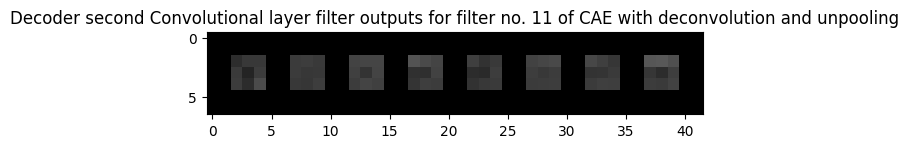

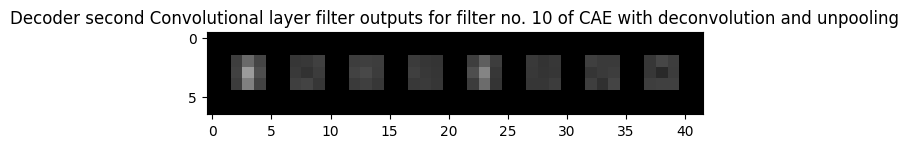

In [66]:
conv_2_filter = model_Q5_c.decoder_conv2[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_c,model_name="CAE with deconvolution and unpooling",device=device,decoder_conv_filter=conv_2_filter,decoder_layer="second")

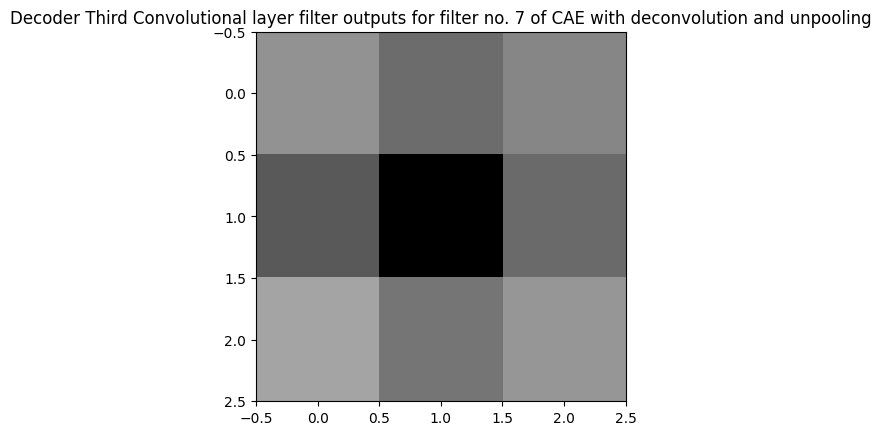

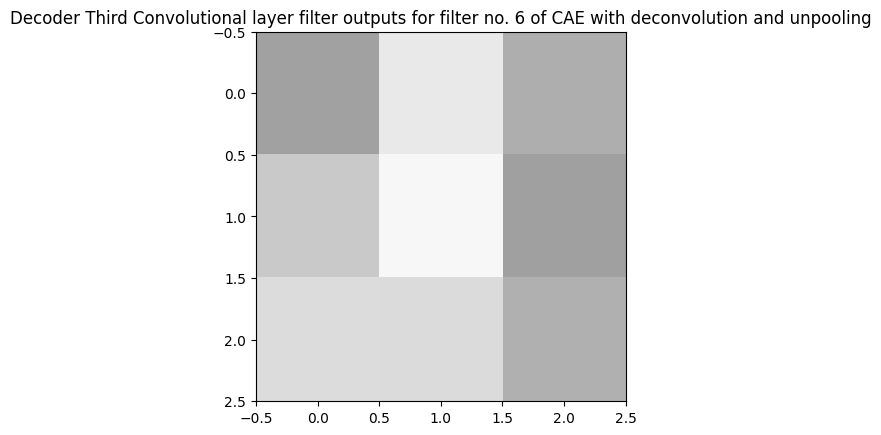

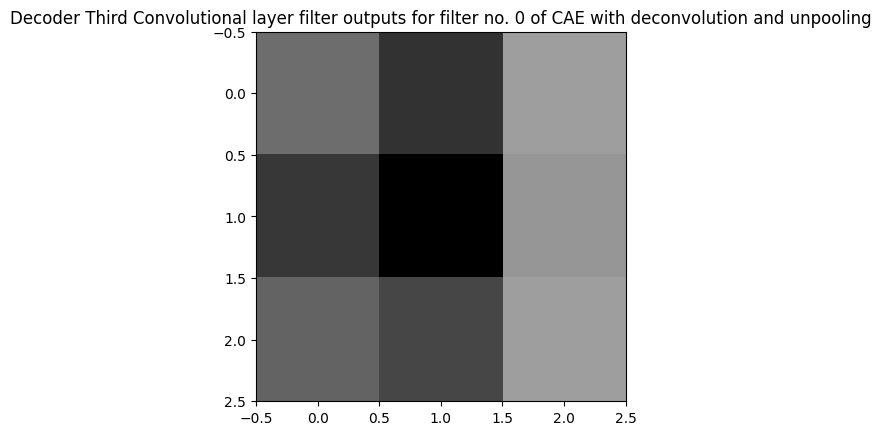

In [67]:
conv_3_filter = model_Q5_c.decoder_conv3[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_c,model_name="CAE with deconvolution and unpooling",device=device,decoder_conv_filter=conv_3_filter,decoder_layer="Third")